---
title: "Análisis de Series de Tiempo en Finanzas"
author: "Fernando J. Terreno"
date: "2025-12-27"
format:
  html:
    toc: true
    toc-depth: 3
    code-fold: true
    theme: cosmo
execute:
  echo: false
  warning: false
  message: false
---



**Resumen:**
En este notebook presento un análisis reproducible de series de tiempo aplicado a datos financieros. Incluye descarga de datos desde Yahoo Finance, cálculo de log-retornos, ajuste y selección de modelos ARMA/ARIMA, y modelado de volatilidad con GARCH. El objetivo es mostrar técnicas de modelado, evaluación y visualización que pueda incluir en mi portfolio técnico.

**Habilidades demostradas:** Data wrangling, visualización, modelado ARMA/ARIMA, selección de modelos, modelado de volatilidad (GARCH), y reproducibilidad de análisis.



In [1]:
#!pip install arch

In [2]:
# Importo las librerías generales
import os                               # Para verificar existencia de archivos
import numpy as np                      # Para operaciones numéricas
import pandas as pd                     # Para manejar y procesar datos en formato tabular (DataFrames)

# Importo las librerías necesarias para graficar
import matplotlib.pyplot as plt              # Para generar gráficos estáticos en Python (API de trazado de matplotlib)

# Importo las librerías de statsmodel
import statsmodels.api as sm                                   # Esta biblioteca contiene funciones estadísticas avanzadas
from statsmodels.tsa.arima_process import arma_generate_sample # arma_generate_sample: función que simula series ARMA/AR/MA
from statsmodels.tsa.stattools import acf, pacf, adfuller      # Test ADF de estacionariedad
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# Importo la librería ARCH
from arch import arch_model

# Importo las librerías de Yahoo Finance
import yfinance as yf          # Para descargar datos financieros desde Yahoo Finance

::: {.content-hidden}
Las versiones de las librerías a utilizar son:
:::

In [3]:
#!pip install session_info

In [4]:
#import session_info
#session_info.show(html=False)

## 1. Simulación de modelos ARMA

Los modelos de análisis de series temporales $AR(n)$, $MA(q)$ y $ARMA(n,q)$ contienen la estructura básica para predecir valores de una serie.

### Modelo $AR(n)$ – Autorregresivo de orden $n$

**Definición:** Un modelo **$AR(n)$** predice el valor actual de una serie temporal como una combinación lineal de sus $n$ valores pasados más un término de error aleatorio.

**Ecuación general:**

$$
X_t = \phi_1 X_{t-1} + \phi_2 X_{t-2} + \dots + \phi_n X_{t-n} + \epsilon_t
$$

Donde:  
- $X_t$ → valor actual de la serie.  
- $\phi_1, \dots, \phi_n$ → coeficientes del modelo (a ajustar con datos).  
- $n$ → orden del modelo (cuántos valores pasados se usan).  
- $\epsilon_t$ → ruido blanco (error aleatorio con media cero y varianza constante).

**Características:**
- Solo depende de valores pasados.  
- Requiere que la serie sea **estacionaria** (media y varianza constantes).  
- Se usa para capturar correlaciones a corto plazo.

**Ejemplo práctico:** Si $n=1$ ($AR(1)$):

$$
X_t = \phi_1 X_{t-1} + \epsilon_t
$$

Aquí el valor actual depende solo del valor anterior más un ruido aleatorio.

### Modelo $MA(q)$ – Media Móvil de orden $q$

**Definición:** Un modelo **MA(q)** representa el valor actual como una combinación lineal de errores pasados.

$$
X_t = \epsilon_t + \theta_1 \epsilon_{t-1} + \dots + \theta_q \epsilon_{t-q}
$$

Donde:  
- $\theta_1, \dots, \theta_q$ → coeficientes de los errores pasados.  
- $\epsilon_t$ → ruido blanco.

**Característica clave:**  
- Captura la dependencia en los errores pasados en lugar de los valores pasados.

### Modelo $ARMA(p,q)$ – Combinación $AR$ y $MA$

***Definición:*** El modelo **ARMA(p, q)** combina ambos enfoques: autorregresivo (AR) y media móvil (MA). Se usa para series estacionarias que tienen dependencias tanto en valores pasados como en errores pasados.

***Ecuación general:***

$$
X_t = \phi_1 X_{t-1} + \dots + \phi_p X_{t-p} + \epsilon_t + \theta_1 \epsilon_{t-1} + \dots + \theta_q \epsilon_{t-q}
$$

Donde:  
- $p$ → orden de la parte $AR$.  
- $q$ → orden de la parte $MA$.

**Características:**
- Muy flexible para modelar series estacionarias.  
- Requiere elegir correctamente los órdenes $p$ y $q$ (por AIC, BIC o autocorrelaciones).

### Resumen rápido

| Modelo | Depende de | Uso principal |
|--------|------------|---------------|
| $AR(n)$  | Valores pasados de la serie | Capturar autocorrelación temporal |
| $MA(q)$  | Errores pasados | Capturar dependencia en los shocks |
| $ARMA(p,q)$ | Valores pasados + errores pasados | Modelar series estacionarias con patrones complejos |

Veamos el siguiente código que implementa un modelo $AR(1)$.

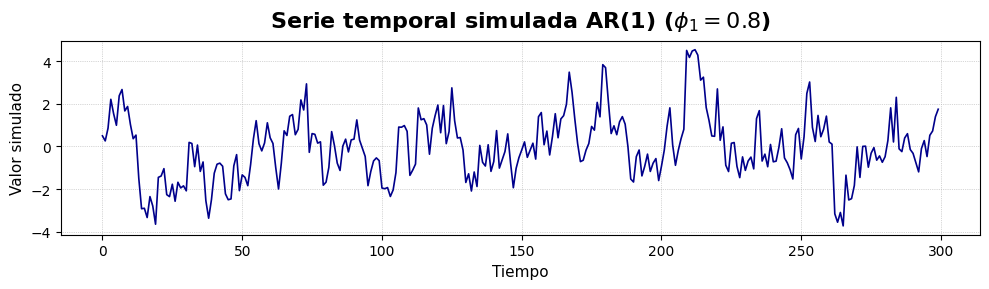

In [34]:
# ======================================
# Generación de una serie temporal AR(1)
# ======================================

# --------------------------------------------------------------------
# Fijamos la semilla del generador aleatorio para reproducibilidad
# Esto garantiza que cada ejecución produzca los mismos resultados
# --------------------------------------------------------------------
np.random.seed(42)

# ------------------------------------------------------------
# Definimos el número de observaciones que tendrá la serie
# En este caso, se generarán 300 puntos de la serie temporal
# ------------------------------------------------------------
n = 300

# -------------------------------------------------------------------------
# Definimos los coeficientes del modelo autorregresivo AR(1)
# IMPORTANTE: la librería arma_generate_sample utiliza el siguiente formato:
#             AR = [1, -phi1, -phi2, ...]
# Por lo tanto, para un modelo AR(1) con phi1 = 0.8 debe escribirse:
#             AR = [1, -0.8]
# Caso contrario, se obtendría un modelo diferente al deseado
# -------------------------------------------------------------------------
ar1 = np.array([1, -0.8])  # Coeficiente φ1 = 0.8 (pero escrito como -0.8 aquí)

# ------------------------------------------------------------------
# Definimos los coeficientes del modelo de media móvil MA
# Si no queremos incluir un término MA (es decir, q = 0),
# simplemente usamos el vector [1]
# ------------------------------------------------------------------
ma1 = np.array([1])

# --------------------------------------------------------------------------------
# Generamos la serie temporal mediante la función arma_generate_sample
# Esta función devuelve una serie sintética que cumple con el modelo ARMA definido
# En este caso, generará una serie AR(1) porque la parte MA es simplemente [1]
# --------------------------------------------------------------------------------
serie_ar1 = arma_generate_sample(ar1, ma1, n)
# ---------------------------------------------------------
# Visualización homogénea de la serie AR(1) simulada
# ---------------------------------------------------------
fig, ax = plt.subplots(figsize=(10,3))

ax.plot(serie_ar1, lw=1.2, color="darkblue")

ax.set_title(
    "Serie temporal simulada AR(1) ($\\phi_1 = 0.8$)",
    fontsize=16,
    fontweight="bold",
    pad=10
)
ax.set_xlabel("Tiempo", fontsize=11)
ax.set_ylabel("Valor simulado", fontsize=11)

ax.grid(True, lw=0.5, ls=":")

plt.tight_layout()
plt.show()


### Visualización: comparación de series AR(1)

En la siguiente celda se generan múltiples realizaciones de un proceso AR(1) variando el parámetro $a_1$. Se muestran los gráficos para comparar visualmente el efecto de la persistencia temporal sobre la apariencia de la serie.

Observación: valores de $|a_1|$ cercanos a 1 incrementan la memoria temporal y la persistencia; valores cercanos a 0 producen series más parecidas a ruido blanco.

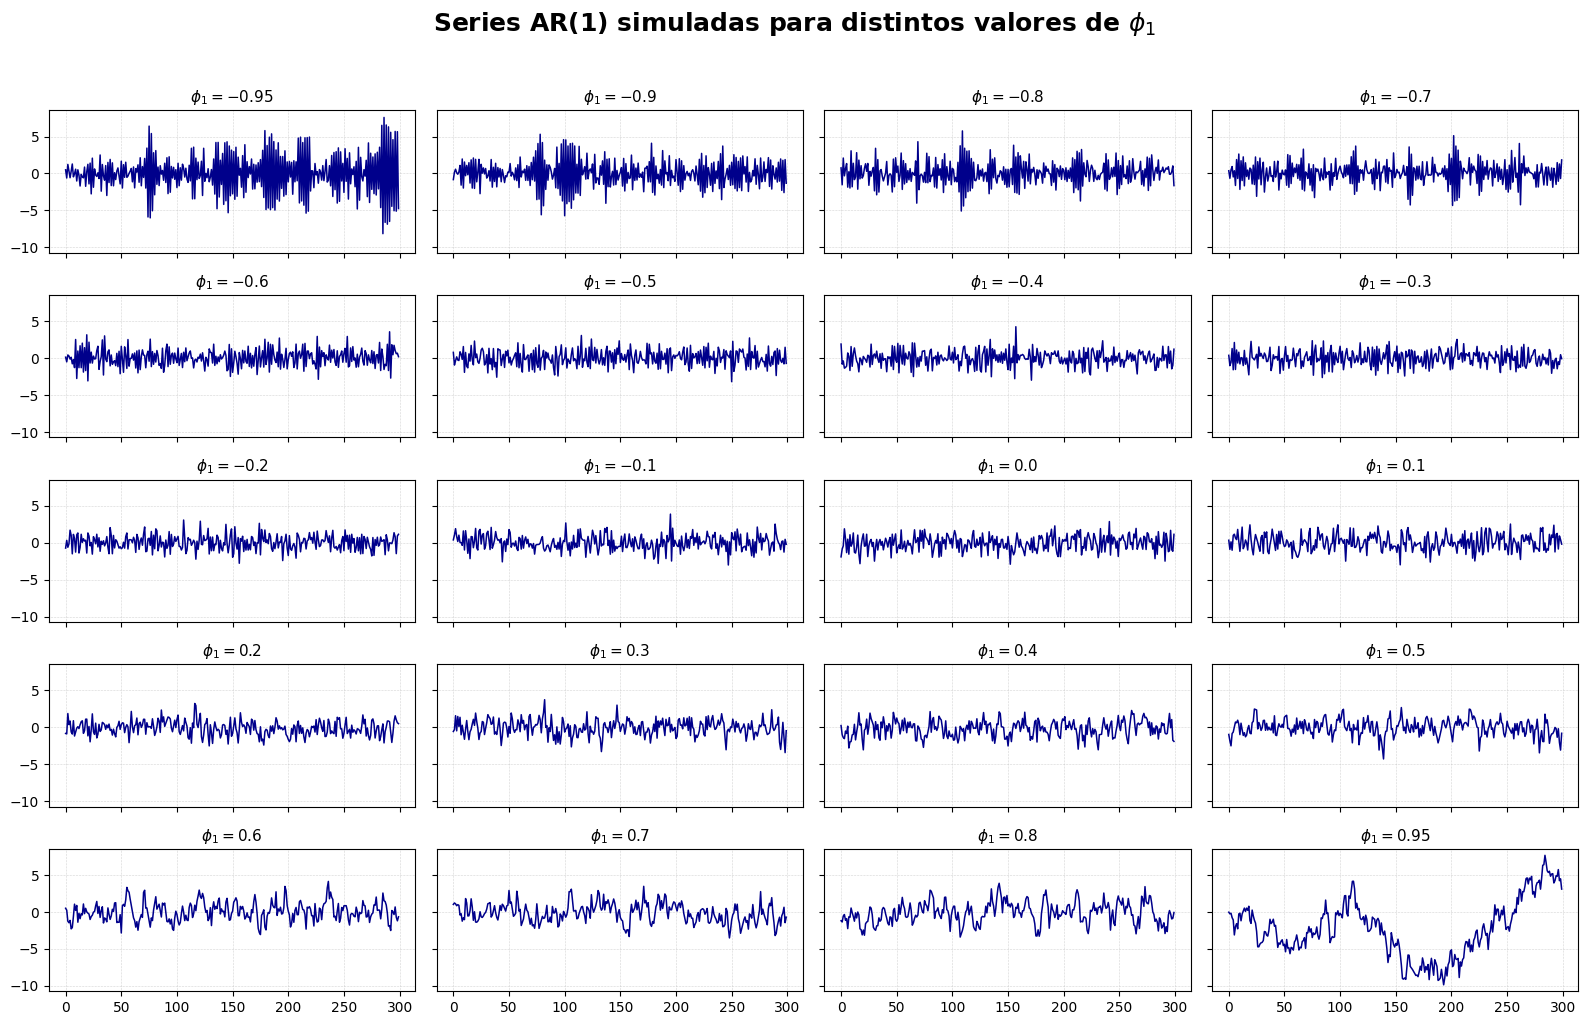

In [6]:
# ================================================================
# EJERCICIO 1: Comparación de series AR(1) para distintos φ₁
# ================================================================

np.random.seed(42)
n = 300

a1_values = [-0.95, -0.9, -0.8, -0.7, -0.6,
             -0.5, -0.4, -0.3, -0.2, -0.1,
              0.0,  0.1,  0.2,  0.3,  0.4,
              0.5,  0.6,  0.7,  0.8,  0.95]

n_rows, n_cols = 5, 4
fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(16, 10),
    sharex=True,
    sharey=True
)
axes = axes.flatten()

for i, a1 in enumerate(a1_values):

    ar_params = np.array([1, -a1])
    ma_params = np.array([1])

    serie = arma_generate_sample(ar_params, ma_params, n)

    ax = axes[i]
    ax.plot(serie, lw=1.1, color="darkblue")
    ax.set_title(f"$\\phi_1 = {a1}$", fontsize=11)
    ax.grid(True, lw=0.4, ls=":")

# Título general de la figura
fig.suptitle(
    "Series AR(1) simuladas para distintos valores de $\\phi_1$",
    fontsize=18,
    fontweight="bold",
    y=1.02
)

plt.tight_layout()
plt.show()


¿Cuál parece más estacionaria?
- La serie con ***$a_{1}$ = 0.3*** es la que aparenta ser más estacionaria, ya que muestra menor dependencia temporal.
- Aunque todas son teóricamente estacionarias porque $|a_{1}|<1$, visualmente ***$a_{1}$ = 0.8*** y ***$a_{1}$ = -0.9*** son teóricamente estacionarias, pero muestran alta persistencia (especialmente −0.9 con oscilaciones marcadas), por lo que parecen menos estacionarias a simple vista.

| Valor ($a_1$) | Comportamiento observado                                                       |
| ----------- | ------------------------------------------------------------------------------ |
| 0.8         | Alta persistencia, cambios suaves, rachas largas del mismo signo.              |
| 0.3         | Menor dependencia temporal, rápida pérdida de memoria, apariencia más ruidosa. |
| -0.9        | Persistencia alta pero **oscilatoria**, cambia de signo con mucha frecuencia.  |

Para analizar las series temporales, también es conveniente utilizar ***ACF*** y ***PACF***.

### ACF – Autocorrelation Function (Función de Autocorrelación)

**Definición:** La ACF mide la **correlación entre una serie temporal y sus valores rezagados (lags)**.
- Es útil para identificar patrones de dependencia temporal en la serie.
- Nos dice hasta qué punto los valores pasados influyen en los valores presentes.

**Fórmula matemática (lag k):**

$$
\rho_k = \frac{\text{Cov}(X_t, X_{t-k})}{\text{Var}(X_t)}
$$

donde:
- $\rho_k$ → autocorrelación en el lag $k$  


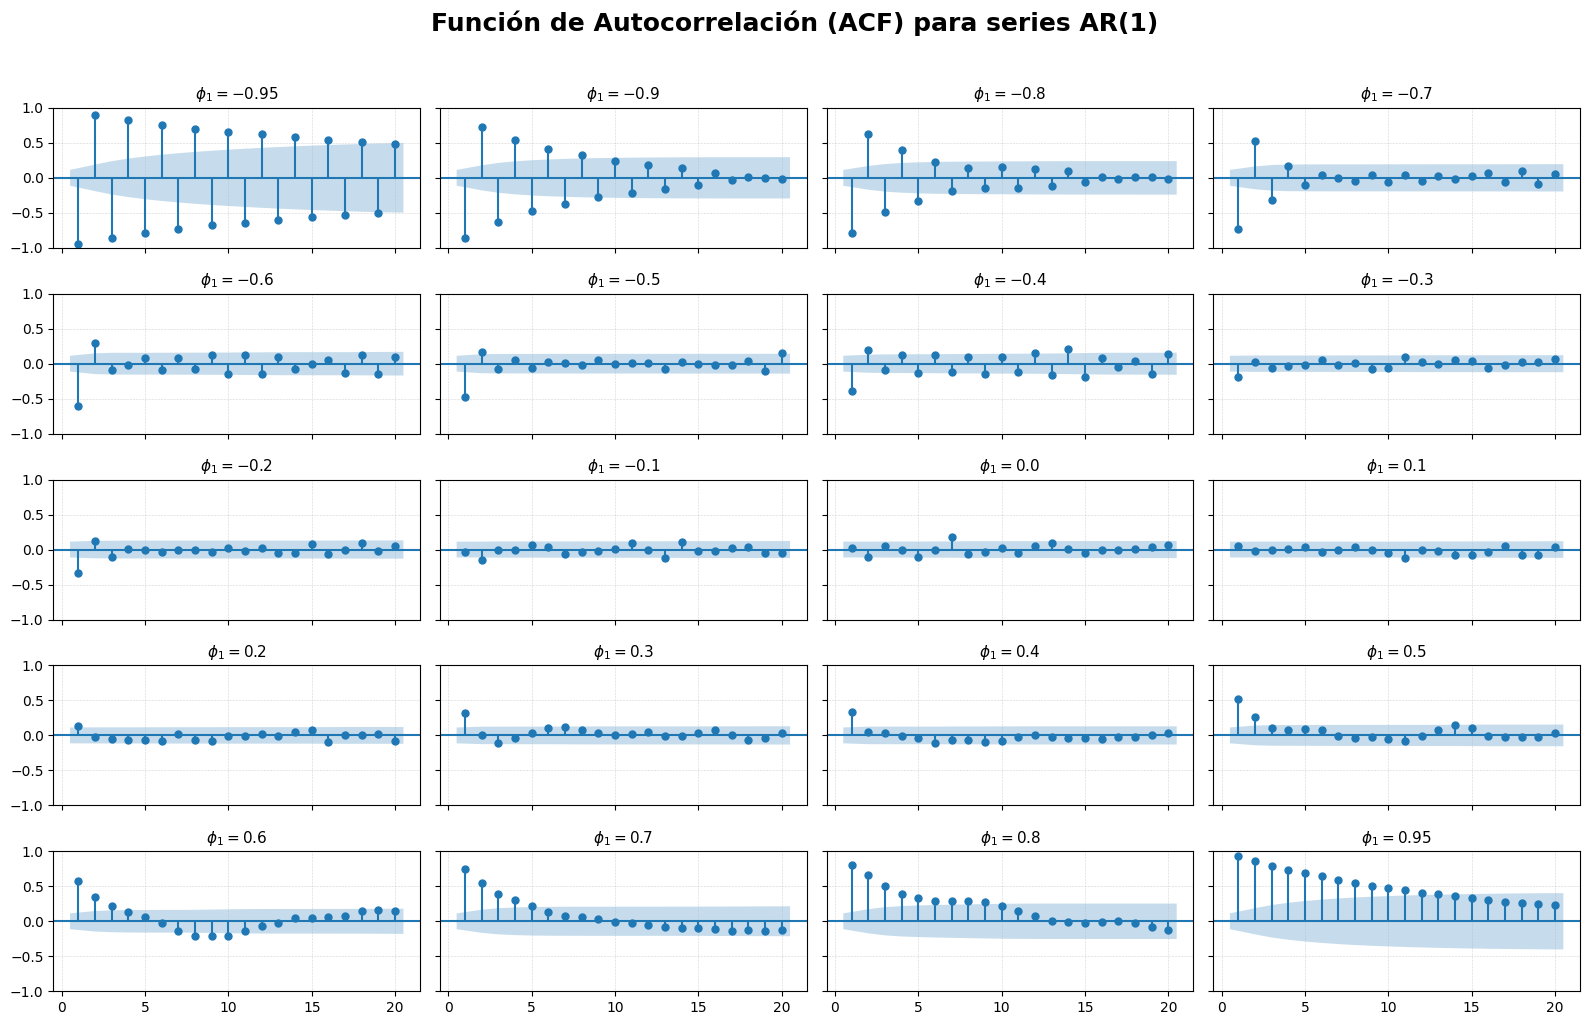

In [7]:
from statsmodels.graphics.tsaplots import plot_acf

rows, cols = 5, 4

fig, axes = plt.subplots(
    rows,
    cols,
    figsize=(16, 10),
    sharex=True,
    sharey=True
)

axes = axes.flatten()

for i, a1 in enumerate(a1_values):

    ar_params = np.array([1, -a1])
    ma_params = np.array([1])

    serie = arma_generate_sample(ar_params, ma_params, n)

    plot_acf(
        serie,
        lags=20,
        ax=axes[i],
        alpha=0.05,
        zero=False
    )

    axes[i].set_title(f"$\\phi_1 = {a1}$", fontsize=11)
    axes[i].grid(True, lw=0.4, ls=":")

# Título general del panel
fig.suptitle(
    "Función de Autocorrelación (ACF) para series AR(1)",
    fontsize=18,
    fontweight="bold",
    y=1.02
)

plt.tight_layout()
plt.show()


Luego, analicemos la función de autocorrelacion parcial.

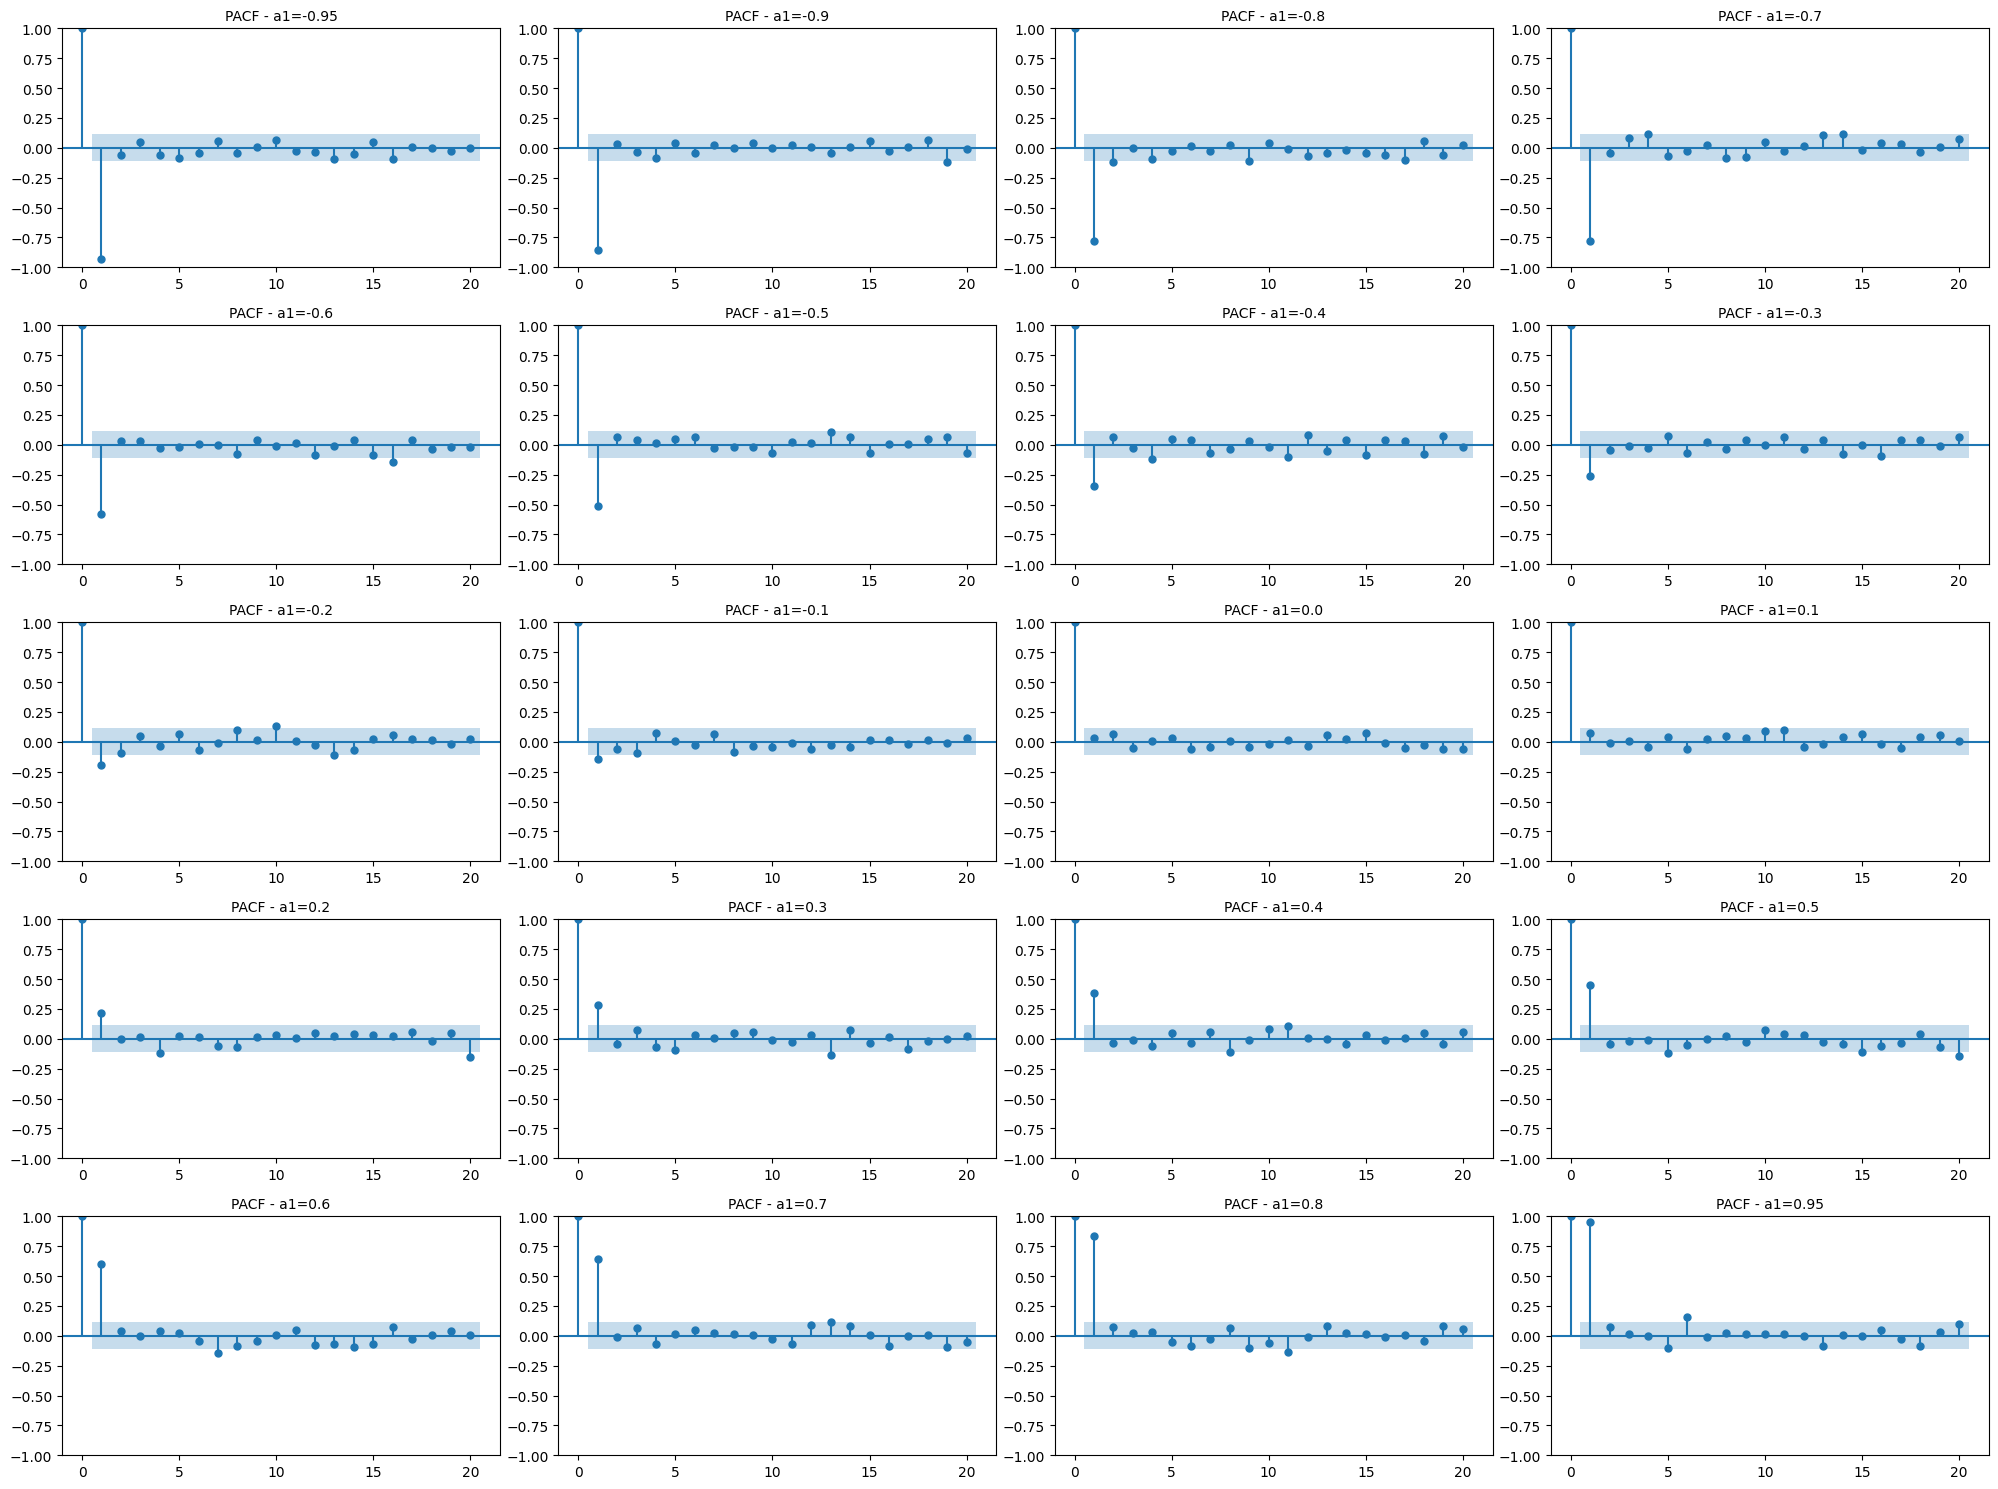

In [8]:
# ============================================================
#                 PANEL DE PACF (Partial ACF)
# ============================================================

# Creamos una nueva figura (fig3) y un arreglo de ejes (axes3)
# con la misma disposición de 5 filas x 4 columnas.
fig3, axes3 = plt.subplots(rows, cols, figsize=(20, 15))

# De nuevo convertimos la estructura de ejes de 2D a 1D
# para iterar fácilmente con índices.
axes3 = axes3.flatten()

# Iteramos nuevamente sobre todos los valores posibles de a1
for i, a1 in enumerate(a1_values):

    # Definimos coeficientes AR con el mismo formato explicado antes.
    ar_params = np.array([1, -a1])

    # Definimos coeficientes MA sin efectos de media móvil.
    ma_params = np.array([1])

    # Generamos una nueva serie AR(1) con la misma longitud n.
    serie = arma_generate_sample(ar_params, ma_params, n)

    # ---------------------------------------------------------
    # Graficamos la PACF (Partial Autocorrelation Function)
    # con 20 rezagos. Se usa la opción method='ywm' (Yule-Walker)
    # que es adecuada para evitar problemas de singularidad.
    # Se especifica el subplot correspondiente usando axes3[i].
    # ---------------------------------------------------------
    plot_pacf(serie, lags=20, ax=axes3[i], method='ywm')

    # Definimos el título identificando el valor del parámetro a1.
    axes3[i].set_title(f"PACF - a1={a1}", fontsize=10)

# Ajustamos el diseño del layout para evitar superposiciones.
plt.tight_layout()

# Finalmente mostramos la figura con todas las PACF generadas.
plt.show()

***Análisis de los resultados obtenidos***

#### Comportamiento de las series según el parámetro $a_{1}$

Los valores de $a_{1}$ elegidos van desde -0.95 a 0.95, lo cual nos permite observar el comportamiento de la serie en toda la zona permitida para estacionariedad de un $AR(1)$, que es:

$$
|a_{1}|<1
$$

Todas las series generadas son estacionarias en teoría, pero muestran grados diferentes de persistencia, es decir, qué tanto el pasado determina el presente:

- Si $a_{1}\sim 0$, la serie se comporta casi como ruido blanco: las observaciones son poco dependientes unas de otras y parecen aleatorias.
- Si $a_{1}$ es positivo y grande (0.7, 0.8, 0.95), la serie exhibe persistencia positiva, lo que significa que si un valor sube o baja, los siguientes tienden a seguir la misma dirección. Se observan tramos largos ascendentes o descendentes; la serie parece más "suave" y menos ruidosa.
- Si $a_{1}$ es negativo y grande en magnitud (-0.7, -0.8, -0.95), la serie muestra alternancia marcada, es decir, cambia de signo rápidamente: si un dato es alto, el siguiente será bajo y viceversa. Esto genera un patrón similar a vibraciones u oscilaciones.
- Cuanto más cercano a $+1$ o $-1$, mayor es la memoria del proceso, es decir, el pasado influye por más tiempo. La serie tarda más en volver a valores promedio, lo que visualmente se traduce en tendencias aparentes, aunque el proceso siga siendo estacionario.

#### Análisis del panel ACF

La ACF mide correlación entre la serie y sus rezagos, por lo que nos indica pérdida de memoria temporal. Resultados observados:

- Valores altos positivos de $a_{1}$ (0.7, 0.8, 0.95): La ACF decayó lentamente y de forma positiva, lo que confirma una fuerte dependencia temporal.
- Valores cercanos a cero (−0.1, 0, 0.1): La ACF cayó rápidamente, aproximadamente en el primer o segundo rezago, lo que es consistente con procesos de baja memoria.
- Valores negativos grandes (−0.7, −0.8, −0.95): La ACF mostró alternancia de signos, típica de procesos con inversión de dirección entre observaciones consecutivas.

En lenguaje visual:

| Valor de (a_1) | Forma de la ACF         | Interpretación              |
| -------------- | ----------------------- | --------------------------- |
| cercano a 0    | cae abruptamente        | memoria corta               |
| positivo alto  | caída lenta positiva    | memoria larga y suavidad    |
| negativo alto  | alternancia oscilatoria | memoria larga con reversión |

#### Conclusión sobre estacionariedad visual

Aunque todos los valores cumplen con la condición teórica $|a_{1}|<1$, en términos prácticos o visuales:
- Los valores muy cercanos a 1 o -1 muestran una estacionariedad débil, ya que la serie tarda mucho en retornar al nivel central.
- Los valores cercanos a 0 muestran estacionariedad más evidente, pues la memoria se pierde rápidamente.

> La serie parece más claramente estacionaria cuando $a_{1}$ está entre −0.4 y 0.4.

#### Conclusión final

| Tipo de comportamiento       | Valores de ( a_1 ) | Observación                                 |
| ---------------------------- | ------------------ | ------------------------------------------- |
| Estacionaria fuerte (visual) | entre -0.4 y 0.4   | ruido moderado, memoria corta               |
| Estacionaria débil           | cerca de ±0.95     | memoria larga, apariencia "no estacionaria" |
| Oscilatoria                  | negativo alto      | alternancia visible en la serie             |

### Ejemplo: Generación de un ARMA(1,1)

A continuación se muestra la generación y análisis de una realización de un modelo ARMA(1,1) con parámetros representativos. Este ejemplo ilustra cómo se comportan ACF y PACF en presencia de componentes AR y MA.

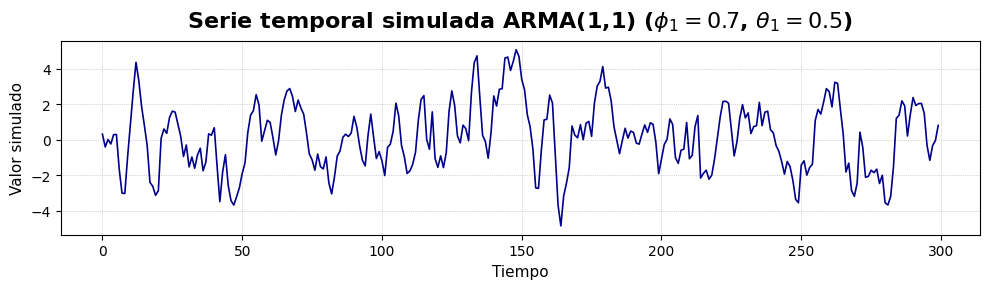

In [9]:
# ==================================================
# Generación y visualización de una serie ARMA(1,1)
# ==================================================

# -------------------------------------------------------
# Parámetros del modelo
# -------------------------------------------------------
phi1 = 0.7      # coeficiente AR(1)
theta1 = 0.5    # coeficiente MA(1)

# Formato requerido por arma_generate_sample
ar = np.array([1, -phi1])
ma = np.array([1, theta1])

# -------------------------------------------------------
# Generación de la serie ARMA(1,1)
# -------------------------------------------------------
serie_arma = arma_generate_sample(ar, ma, nsample=n)

# -------------------------------------------------------
# Visualización homogénea
# -------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 3))

ax.plot(serie_arma, lw=1.2, color="darkblue")

ax.set_title(
    "Serie temporal simulada ARMA(1,1) ($\\phi_1 = 0.7$, $\\theta_1 = 0.5$)",
    fontsize=16,
    fontweight="bold",
    pad=10
)
ax.set_xlabel("Tiempo", fontsize=11)
ax.set_ylabel("Valor simulado", fontsize=11)

ax.grid(True, lw=0.5, ls=":")

plt.tight_layout()
plt.show()


Partiendo del código anterior:

- Generar y graficar una serie **ARMA(2,1)** y otra **MA(2)**.  
- Comparar sus ACF y PACF.

Primero empecemos analizando un modelo de ***MA(2)***, con sus respectivos análisis de ACF y PACF.

### Modelo MA(2)

En lo que sigue, analizaremos la serie temporal ***MA(2)*** graficamente. Para este modelo se requiere dos parámetros, dados por $\theta_{1}$ y $\theta_{2}$. Para empezar, fijaremos $\theta_{2}$.

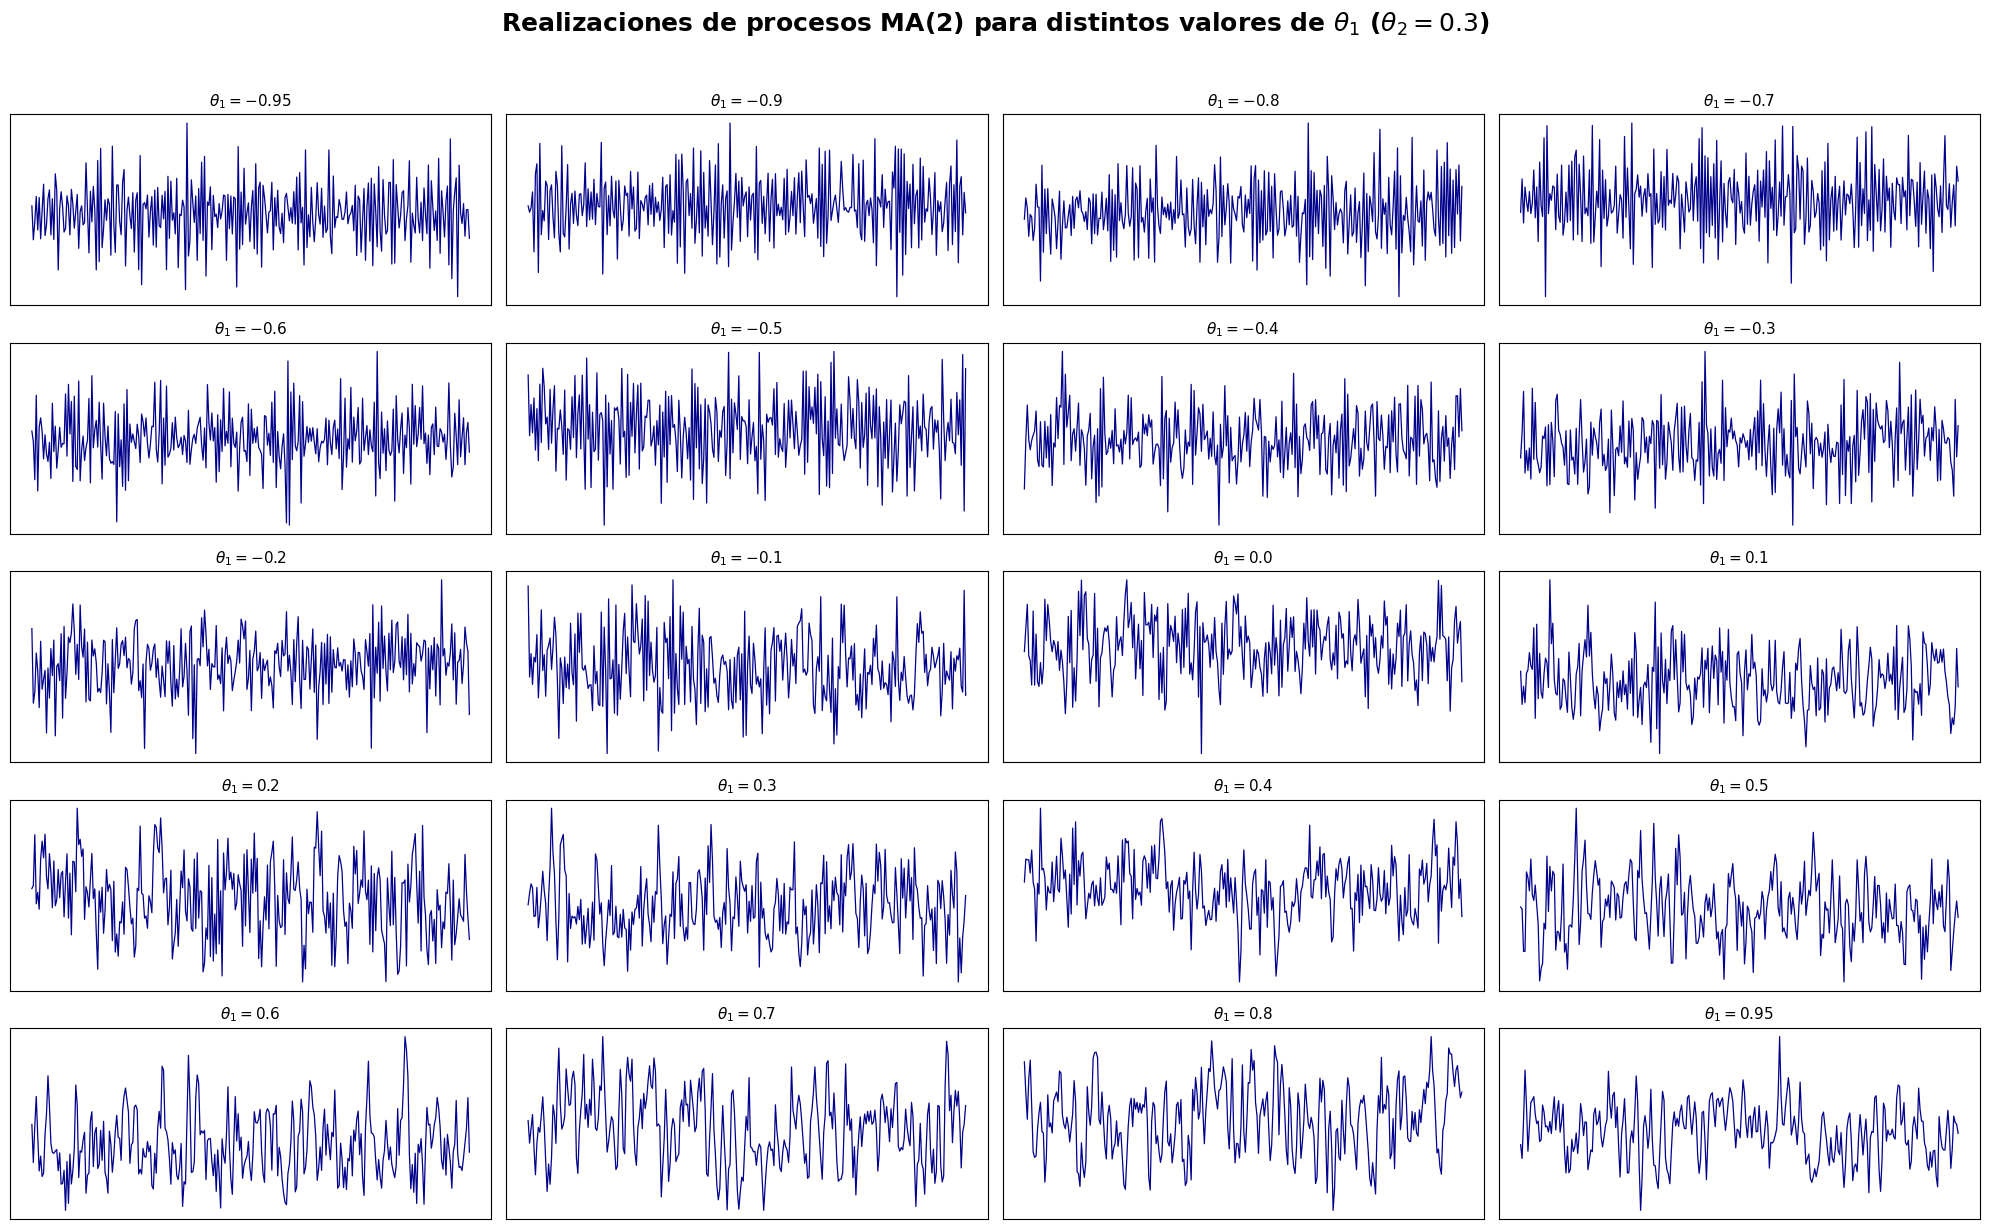

In [10]:
# ===========================================================
# Comparación de realizaciones MA(2) para distintos valores de θ1
# ===========================================================

# -------------------------------------------------------
# Parámetros generales
# -------------------------------------------------------
n = 300
theta2 = 0.3

theta1_values = [-0.95, -0.9, -0.8, -0.7, -0.6,
                 -0.5, -0.4, -0.3, -0.2, -0.1,
                  0.0,  0.1,  0.2,  0.3,  0.4,
                  0.5,  0.6,  0.7,  0.8,  0.95]

# -------------------------------------------------------
# Grilla de subplots
# -------------------------------------------------------
rows, cols = 5, 4
fig, axes = plt.subplots(rows, cols, figsize=(20, 12))
axes = axes.flatten()

# -------------------------------------------------------
# Almacenamiento de estadísticas resumidas
# -------------------------------------------------------
results = []

# ==================================================
# Generación y visualización de series MA(2)
# ==================================================
for i, theta1 in enumerate(theta1_values):

    ar = np.array([1])
    ma = np.array([1, theta1, theta2])

    serie = arma_generate_sample(ar, ma, nsample=n)

    # Estadísticas básicas
    mean_emp = serie.mean()
    var_emp = serie.var(ddof=1)
    adf_stat, adf_pval = adfuller(serie, autolag="AIC")[:2]

    results.append({
        "theta1": theta1,
        "theta2": theta2,
        "mean": mean_emp,
        "var": var_emp,
        "adf_stat": adf_stat,
        "adf_pval": adf_pval
    })

    ax = axes[i]
    ax.plot(serie, lw=0.9, color="darkblue")
    ax.set_title(f"$\\theta_1 = {theta1}$", fontsize=11)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(True, lw=0.4, ls=":")

# -------------------------------------------------------
# Título general y layout
# -------------------------------------------------------
fig.suptitle(
    f"Realizaciones de procesos MA(2) para distintos valores de $\\theta_1$ ($\\theta_2 = {theta2}$)",
    fontsize=18,
    fontweight="bold",
    y=1.02
)

plt.tight_layout()
plt.show()


Veamos ahora la función de autocorrelación de $MA(2)$ correspondiente a las figuras anteriores.

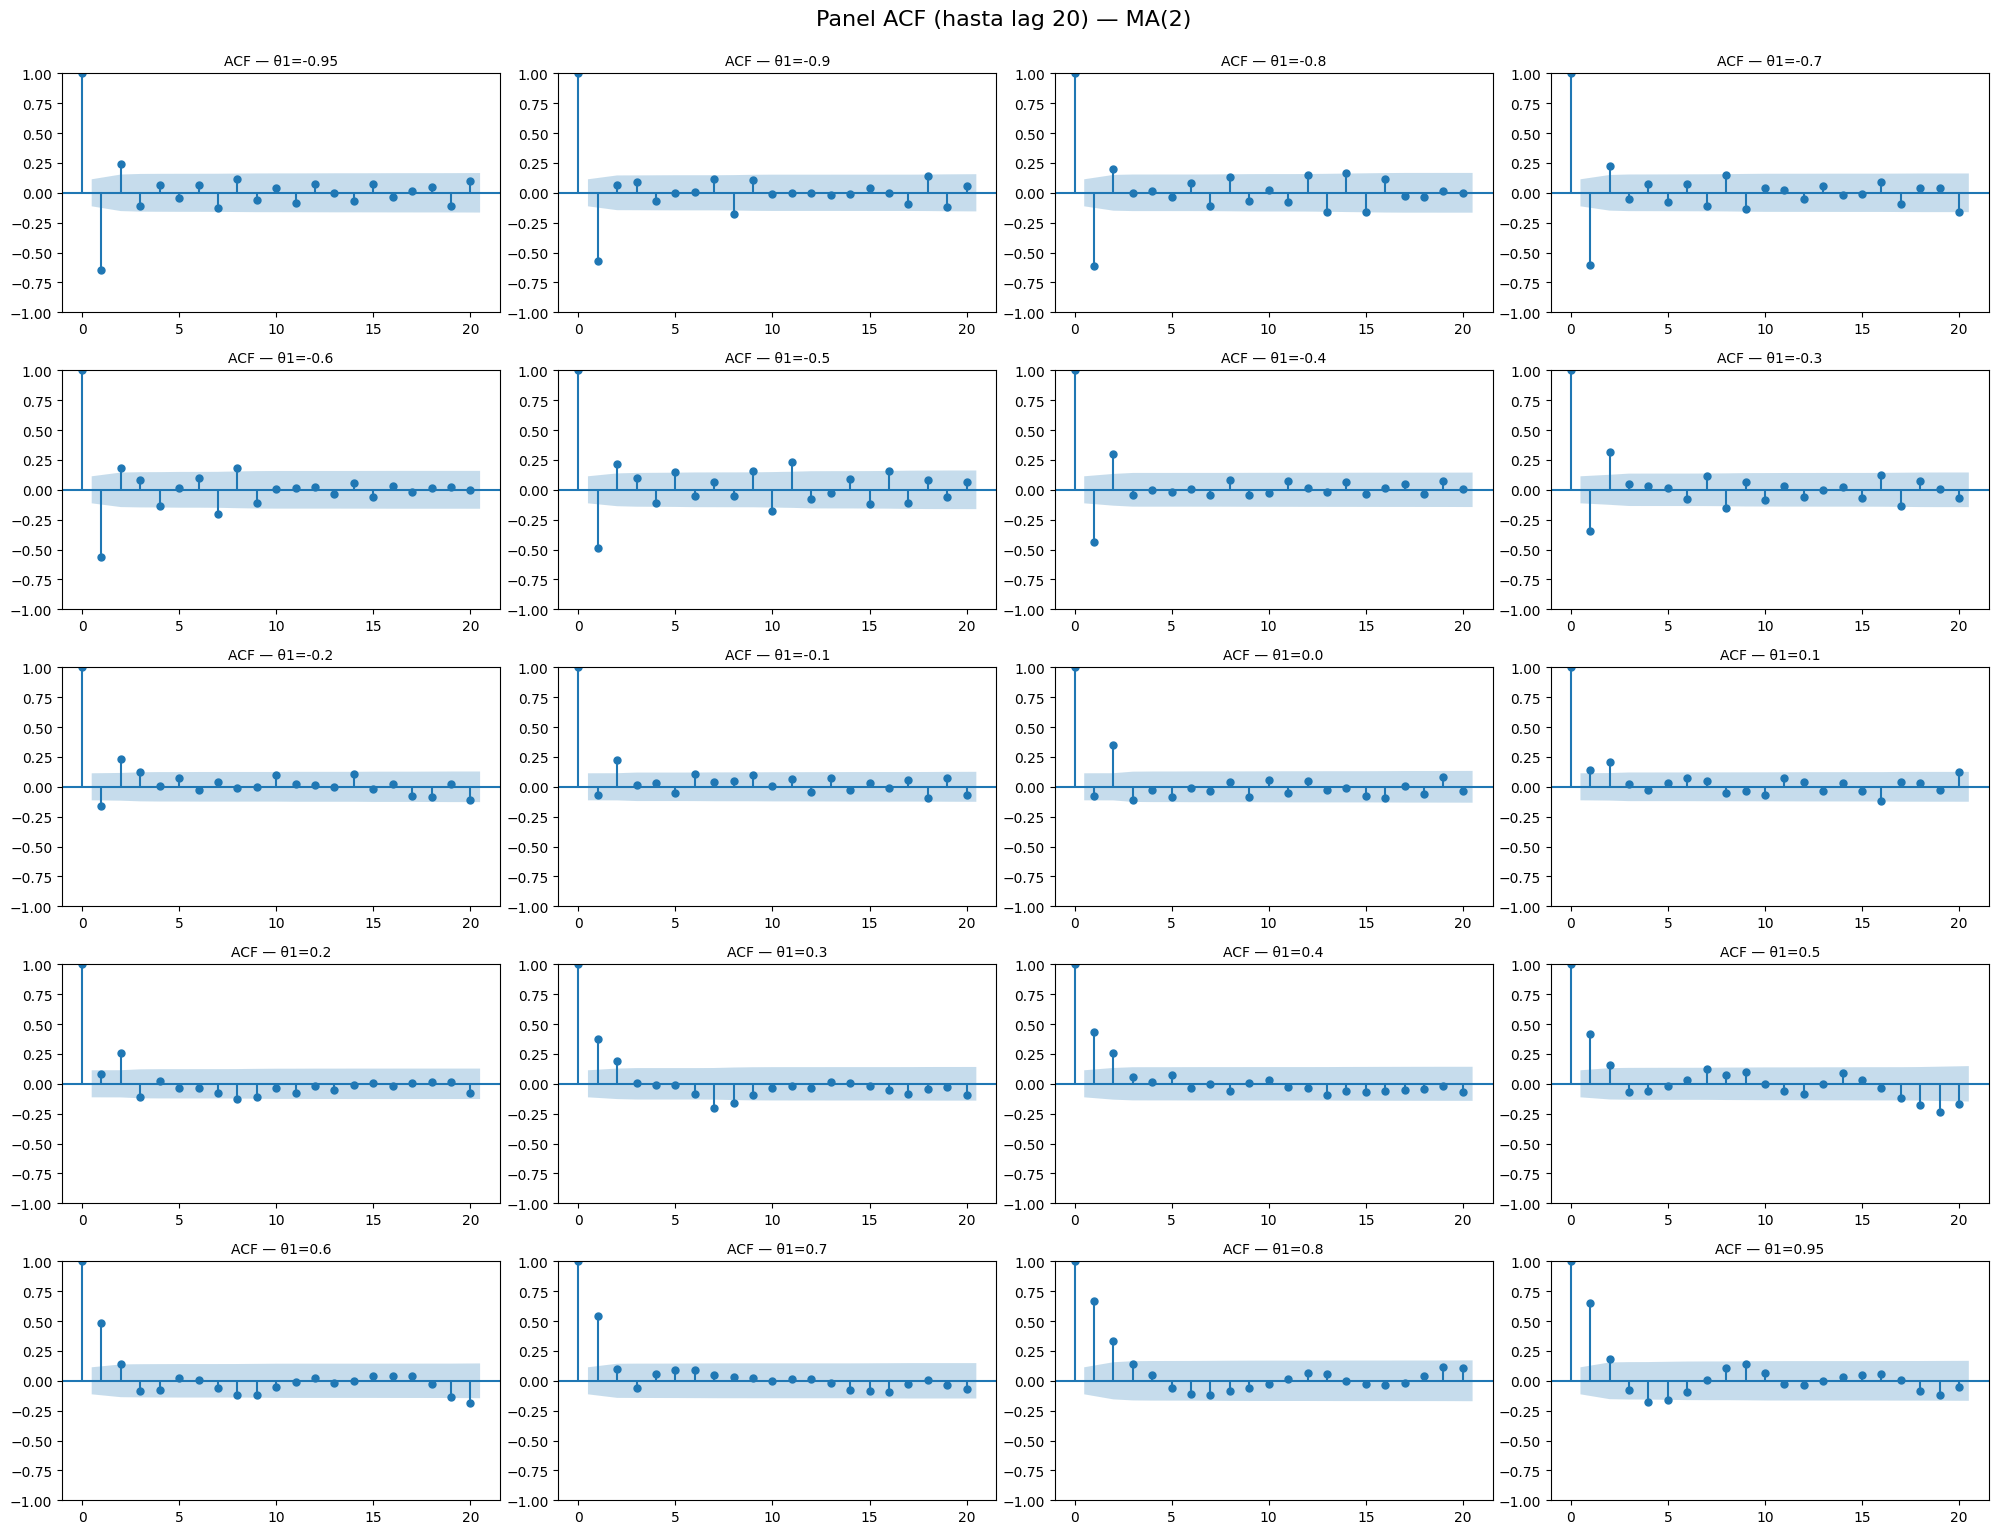

In [11]:
# =====================================================
# PANEL DE ACF: graficamos ACF para cada serie generada
# =====================================================
fig_acf, axes_acf = plt.subplots(rows, cols, figsize=(20, 15))
axes_acf = axes_acf.flatten()

for i, theta1 in enumerate(theta1_values):
    ar = np.array([1])
    ma = np.array([1, theta1, theta2])
    serie_ma = arma_generate_sample(ar, ma, nsample=n)   # generamos la misma estructura (nueva realización)

    # plot_acf dibuja correlograma con bandas de confianza
    plot_acf(serie_ma, lags=20, ax=axes_acf[i])
    axes_acf[i].set_title(f"ACF — θ1={theta1}", fontsize=10)

plt.tight_layout()
plt.suptitle("Panel ACF (hasta lag 20) — MA(2)", y=1.02, fontsize=16)
plt.show()

De igual forma, analicemos la función de autocorrelación parcial de $MA(2)$.

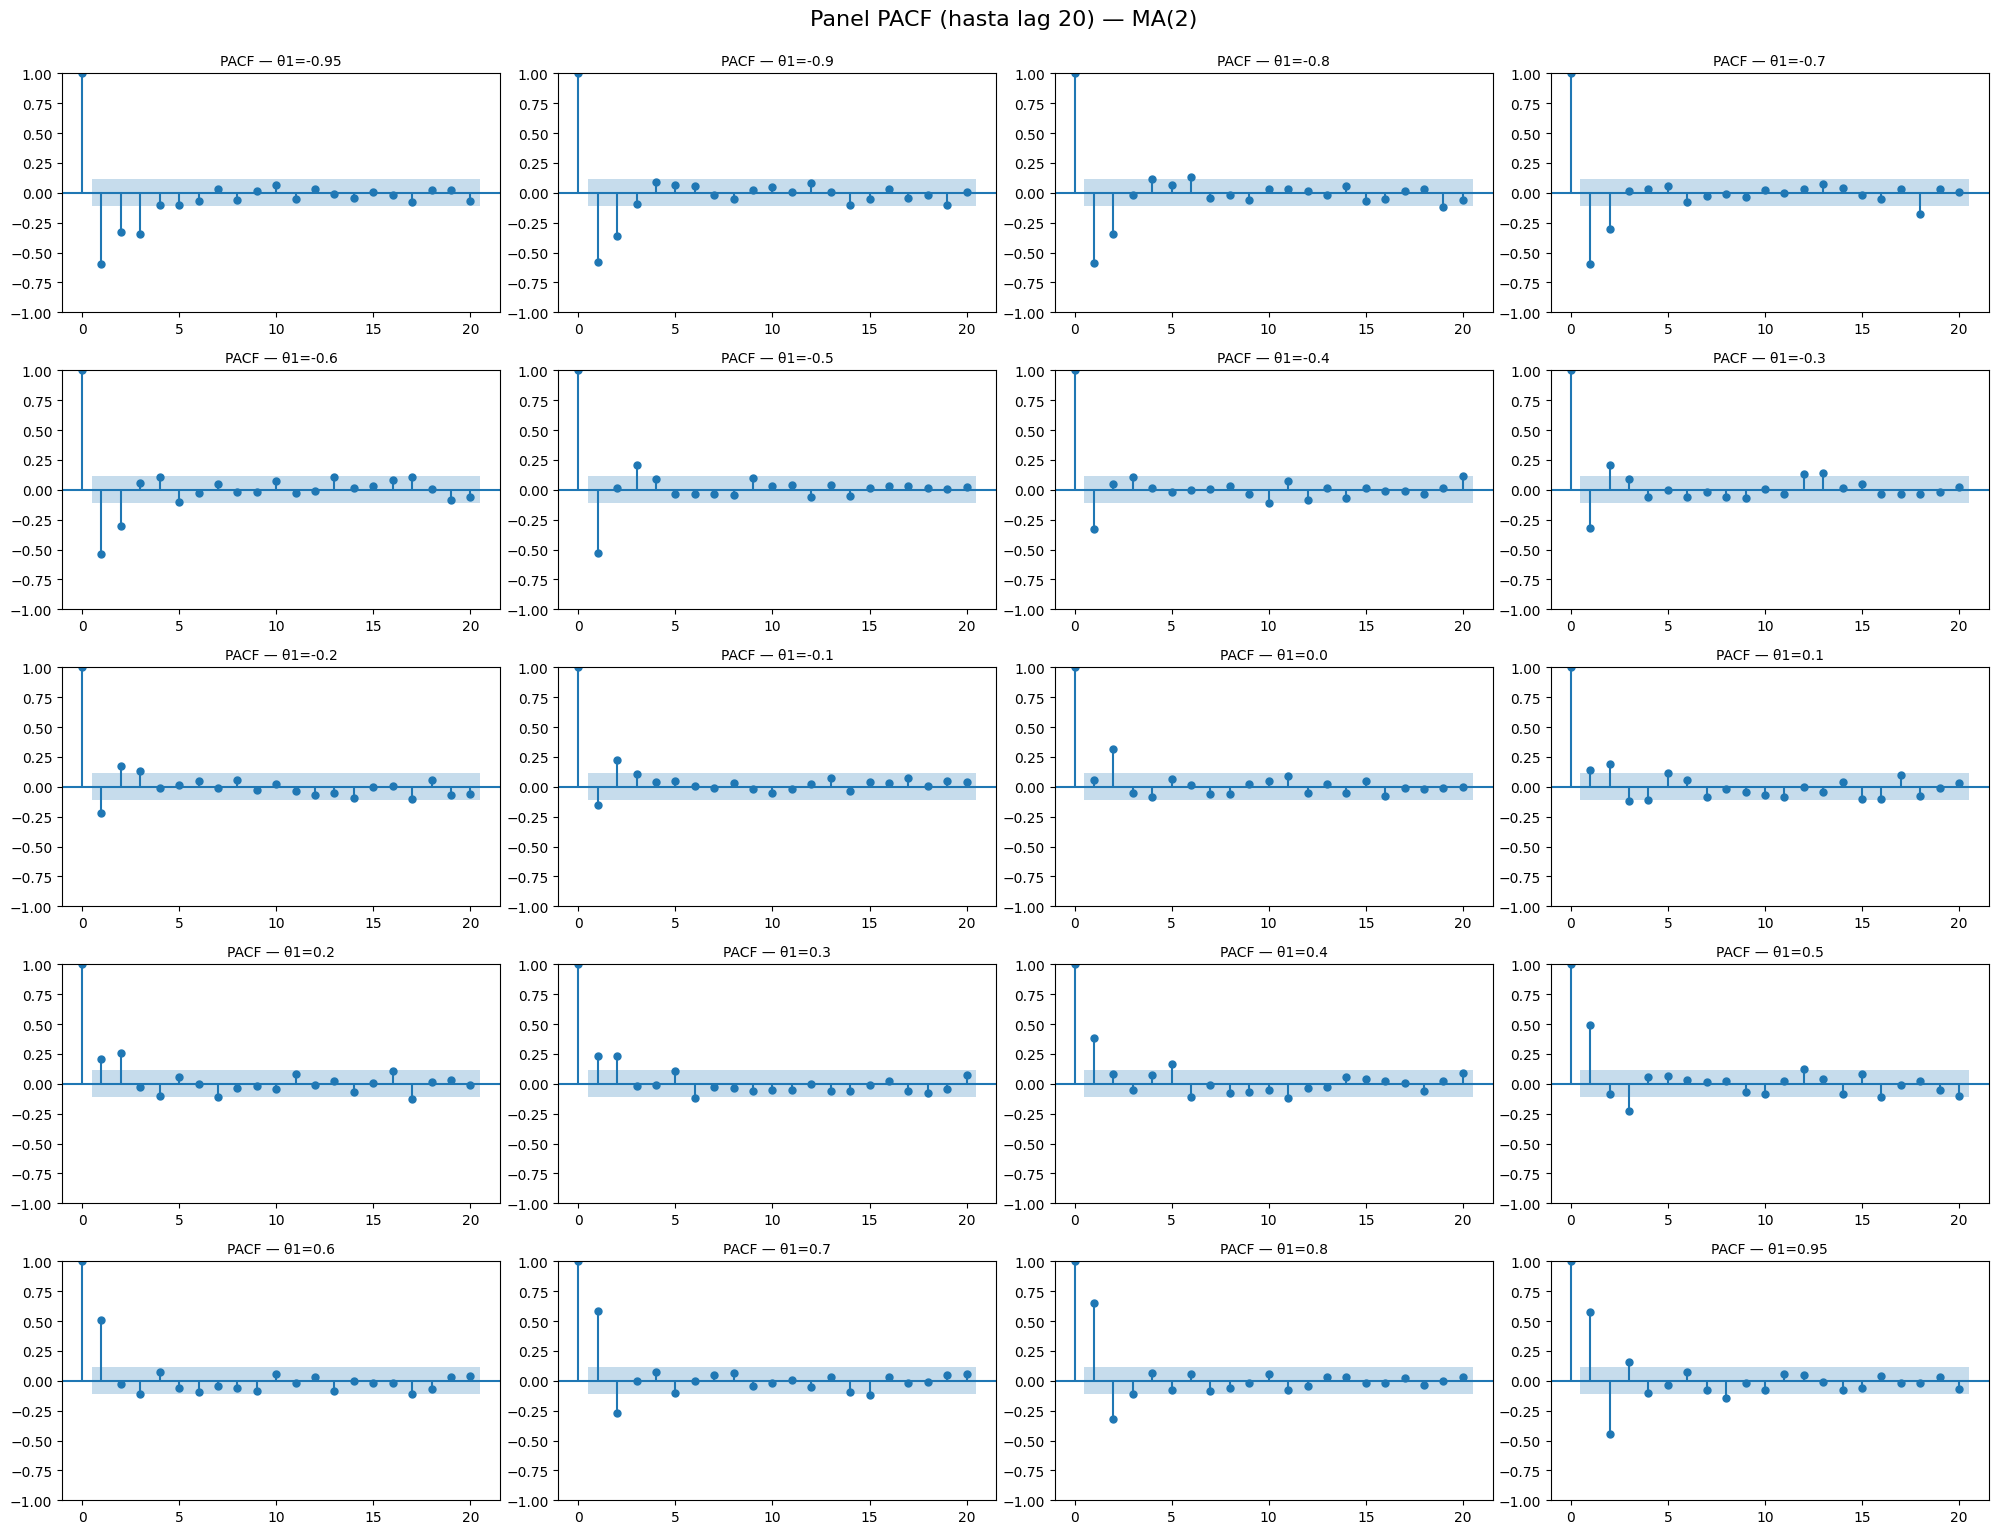

In [12]:
# =======================================================
# PANEL DE PACF: graficamos PACF para cada serie generada
# =======================================================
fig_pacf, axes_pacf = plt.subplots(rows, cols, figsize=(20, 15))
axes_pacf = axes_pacf.flatten()

for i, theta1 in enumerate(theta1_values):
    ar = np.array([1])
    ma = np.array([1, theta1, theta2])
    serie_ma = arma_generate_sample(ar, ma, nsample=n)

    # plot_pacf muestra la autocorrelación parcial
    plot_pacf(serie_ma, lags=20, ax=axes_pacf[i], method='ywm')  # 'ywm' o 'ld' son opciones robustas
    axes_pacf[i].set_title(f"PACF — θ1={theta1}", fontsize=10)

plt.tight_layout()
plt.suptitle("Panel PACF (hasta lag 20) — MA(2)", y=1.02, fontsize=16)
plt.show()

#### Análisis e interpretación

***Estacionariedad***
- *Teóricamente*: cualquier $MA(q)$ es siempre estacionario (la condición de estacionariedad para AR es distinta y no aplica aquí). Por lo tanto, todas las series $MA(2)$ generadas son estacionarias en sentido estricto.
- *Visualmente*: series con coeficientes $\theta$ grandes en magnitud (por ejemplo $±0.9$, $±0.95$) pueden mostrar patrones aparentes de dependencia a corto plazo o picos más marcados y de mayor magnitud. Sin embargo, esto no significa no estacionariedad.

***ACF (Autocorrelación)***
- Para un $MA(2)$ ideal, la ACF debe cortar bruscamente después del lag 2. Es decir: ACF significativa en lags 1 y 2 y aproximadamente nula (fuera de bandas) para lags > 2.
- En las realizaciones finitas simuladas vemos ruido muestral: a veces aparecen lags fuera de las bandas por azar, especialmente cuando $|\theta|$ es grande (aumento de varianza muestral).
- La ACF muestra mayoritariamente significancia solo en los dos primeros rezagos y luego cae dentro de bandas, eso confirma la estructura $MA(2)$.

***PACF (Autocorrelación parcial)***
- En contraste con la ACF, la PACF de un $MA(2)$ no corta de forma nítida en lag 2; en general decae gradualmente (comportamiento típico de un MA es PACF con decaimiento). Es decir: ACF corta en $q$, PACF decae — regla práctica para identificar $MA(q)$.

***Efecto del signo y magnitud de $\theta_{1}$ (con $\theta_{2}$ fijo = 0.3)***
- $\theta_{1}$ positivo: contribuye a correlaciones positivas en rezagos 1 y (a través de combinaciones) en rezago 2. En la serie, puede observarse una leve suavidad a escala pequeña.
- $\theta_{1}$ negativo: tiende a producir correlaciones negativas en el rezago 1; dependiendo del signo y magnitud de $\theta_{2}$, pueden aparecer oscilaciones a muy corto plazo.
- Magnitud grande ($|\theta_{1}|$ cercano a 1): aumenta la varianza de la serie y la influencia de los choques recientes; la ACF en los primeros dos lags es más pronunciada.

***Conclusiones***
- Confirmación estructural: los ACF muestran corte aproximadamente en lag 2 y PACF decaimiento, entonces los gráficos coinciden con un $MA(2)$.
- Dependencia de parámetros: al aumentar $\theta_{1}$ la ACF en lags 1 y 2 se hace más evidente; con $\theta_{1}$ negativo debemos controlar el signo de lag 1.
- Estacionariedad práctica: todas estacionarias por construcción, pero las de mayor magnitud pueden aparentar “dependencia” fuerte.

En lo que sigue, repite la simulación muchas veces para cada par ($\theta_{1}$,$\theta_{2}$), calcula promedios y medidas de variabilidad (desvío estándar) de estadísticas relevantes (media, varianza, ACF y PACF por rezago).

In [13]:
# ===================================================================
# Repetición de simulaciones por cada par (theta1, theta2) para MA(2)
# ===================================================================

# Número de repeticiones por par (θ1, θ2)
# Aumentá este valor si querés estimaciones de variabilidad más precisas.
n_sims = 200

# Máximo lag para calcular ACF/PACF (se calculan de 0..max_lag)
max_lag = 20

# -------------------------------------------------------
# Definimos las grillas de parámetros (θ1 y θ2) que queremos explorar.
# Aquí por defecto tomo:
# - theta1_values: misma grilla que usaste para AR/MA antes
# - theta2_values: una lista corta para combinar (podés ampliar)
# -------------------------------------------------------
theta1_values = [-0.95, -0.9, -0.8, -0.7, -0.6,
                 -0.5, -0.4, -0.3, -0.2, -0.1,
                  0.0,  0.1,  0.2,  0.3,  0.4,
                  0.5,  0.6,  0.7,  0.8,  0.95]

# Elegimos algunos valores para theta2; podés usar una sola constante
theta2_values = [0.0, 0.3, -0.3]

# -------------------------------------------------------
# Reserva de estructura para almacenar resultados agregados
# Cada fila de results_list corresponderá a una combinación (θ1, θ2)
# y contendrá medias y stds de las cantidades simuladas.
# -------------------------------------------------------
results_list = []

# -------------------------------------------------------
# Bucle principal: para cada par (theta1, theta2)
# -------------------------------------------------------
# Nota: el cálculo es costoso si hay muchas combinaciones y n_sims grande.
# Ajustá n_sims según tiempo que quieras invertir.
# -------------------------------------------------------
for theta2 in theta2_values:                       # iteramos sobre θ2
    for theta1 in theta1_values:                    # iteramos sobre θ1

        # -----------------------------------------------------------
        # Para cada par preparamos arrays para acumular resultados
        # de cada réplica/simulación.
        # -----------------------------------------------------------
        means = np.empty(n_sims)            # media empírica de cada réplica
        vars_ = np.empty(n_sims)            # varianza empírica de cada réplica
        adf_stats = np.empty(n_sims)        # estadístico ADF por réplica
        adf_pvals = np.empty(n_sims)        # p-valor ADF por réplica

        # acf_vals y pacf_vals guardan ACF/PACF para lags 0..max_lag por réplica
        # dimensiones: (n_sims, max_lag+1)
        acf_vals = np.empty((n_sims, max_lag + 1))
        pacf_vals = np.empty((n_sims, max_lag + 1))

        # -----------------------------------------------------------
        # Realizamos las n_sims simulaciones para este par (theta1, theta2)
        # -----------------------------------------------------------
        for sim in range(n_sims):
            # -------------------------------------------------------
            # Definimos los vectores ar y ma en el formato de arma_generate_sample:
            #   ar = [1]  (proceso sin parte AR)
            #   ma = [1, theta1, theta2]  (MA(2) con los coeficientes dados)
            # -------------------------------------------------------
            ar = np.array([1])
            ma = np.array([1, theta1, theta2])

            # -------------------------------------------------------
            # Generamos la serie MA(2) de longitud n.
            # arma_generate_sample genera ruido blanco internamente y aplica
            # los coeficientes MA para construir la serie.
            # -------------------------------------------------------
            serie = arma_generate_sample(ar, ma, nsample=n)

            # -------------------------------------------------------
            # Estadísticas por réplica
            # -------------------------------------------------------
            means[sim] = serie.mean()                # media muestral
            vars_[sim] = serie.var(ddof=1)           # varianza muestral (ddof=1)
            adf_res = adfuller(serie, autolag='AIC') # test ADF (tupla)
            adf_stats[sim] = adf_res[0]              # estadístico ADF
            adf_pvals[sim] = adf_res[1]              # p-valor ADF

            # -------------------------------------------------------
            # Calculamos ACF y PACF numéricas (no gráficas) hasta max_lag.
            # - acf(..., fft=False) para mayor estabilidad en series cortas.
            # - pacf(..., method='ywm') para estimador robusto de PACF.
            # -------------------------------------------------------
            acf_vals[sim, :] = acf(serie, nlags=max_lag, fft=False)
            pacf_vals[sim, :] = pacf(serie, nlags=max_lag, method='ywm')

        # -----------------------------------------------------------
        # Una vez hechas las n_sims repeticiones, calculamos las medidas
        # agregadas: media y desviación estándar (variabilidad entre réplicas)
        # para cada estadística de interés.
        # -----------------------------------------------------------

        # medias y stds de media y varianza empíricas
        mean_of_means = np.mean(means)
        std_of_means = np.std(means, ddof=1)
        mean_of_vars = np.mean(vars_)
        std_of_vars = np.std(vars_, ddof=1)

        # ADF: media y std del estadístico y del p-valor
        mean_adf_stat = np.mean(adf_stats)
        std_adf_stat = np.std(adf_stats, ddof=1)
        mean_adf_pval = np.mean(adf_pvals)
        std_adf_pval = np.std(adf_pvals, ddof=1)

        # ACF: calculamos media y std por rezago (vector de longitud max_lag+1)
        acf_mean_by_lag = np.mean(acf_vals, axis=0)
        acf_std_by_lag = np.std(acf_vals, axis=0, ddof=1)

        # PACF: media y std por rezago
        pacf_mean_by_lag = np.mean(pacf_vals, axis=0)
        pacf_std_by_lag = np.std(pacf_vals, axis=0, ddof=1)

        # -----------------------------------------------------------
        # Guardamos en el listado de resultados un diccionario con:
        # - parámetros (θ1, θ2)
        # - resúmenes numéricos (medias, stds)
        # - vectores de ACF/PACF medios y stds (los guardamos como listas
        #   para que pandas pueda manejar correctamente la columna)
        # -----------------------------------------------------------
        results_list.append({
            'theta1': theta1,
            'theta2': theta2,
            'n_sims': n_sims,
            'mean_of_means': mean_of_means,
            'std_of_means': std_of_means,
            'mean_of_vars': mean_of_vars,
            'std_of_vars': std_of_vars,
            'mean_adf_stat': mean_adf_stat,
            'std_adf_stat': std_adf_stat,
            'mean_adf_pval': mean_adf_pval,
            'std_adf_pval': std_adf_pval,
            'acf_mean_by_lag': acf_mean_by_lag.tolist(),    # lista de floats
            'acf_std_by_lag': acf_std_by_lag.tolist(),
            'pacf_mean_by_lag': pacf_mean_by_lag.tolist(),
            'pacf_std_by_lag': pacf_std_by_lag.tolist()
        })

# -------------------------------------------------------
# Convertimos la lista de resultados a DataFrame para revisar fácilmente.
# Para facilitar la lectura mostramos columnas resumen y dejamos las series acf/pacf en columnas separadas.
# -------------------------------------------------------
df_results = pd.DataFrame(results_list)



In [14]:
#| echo: false
#| warning: false
#| message: false

cols_resumen = [
    "theta1", "theta2", "n_sims",
    "mean_of_means", "std_of_means",
    "mean_of_vars", "std_of_vars",
    "mean_adf_stat", "mean_adf_pval"
]

df_results[cols_resumen].head(10)

theta1  theta2  n_sims  mean_of_means  std_of_means  mean_of_vars  \
0   -0.95     0.0     200       0.000119      0.004415      1.902363   
1   -0.90     0.0     200       0.000020      0.006205      1.793740   
2   -0.80     0.0     200      -0.000594      0.010937      1.642853   
3   -0.70     0.0     200      -0.000463      0.017858      1.488838   
4   -0.60     0.0     200      -0.001020      0.024043      1.376416   
5   -0.50     0.0     200       0.001708      0.029715      1.262560   
6   -0.40     0.0     200      -0.003034      0.034613      1.174939   
7   -0.30     0.0     200      -0.005058      0.043765      1.099349   
8   -0.20     0.0     200      -0.000149      0.045664      1.043163   
9   -0.10     0.0     200       0.000248      0.056209      1.008716   

   std_of_vars  mean_adf_stat  mean_adf_pval  
0     0.187671      -8.832698   3.310854e-08  
1     0.204662      -9.228208   2.277945e-08  
2     0.163576      -9.953918   6.598384e-07  
3     0.141471     -11.221103   1.932433e-06  
4     0.136761     -12.637291   1.420207e-06  
5     0.116593     -13.649931   1.155604e-04  
6     0.107974     -15.012551   1.541491e-08  
7     0.094162     -16.100777   8.552719e-06  
8     0.092950     -17.419750   2.387407e-05  
9     0.076811     -16.869172   3.442620e-06

Veamos algunas gráficas de los datos obtenidos

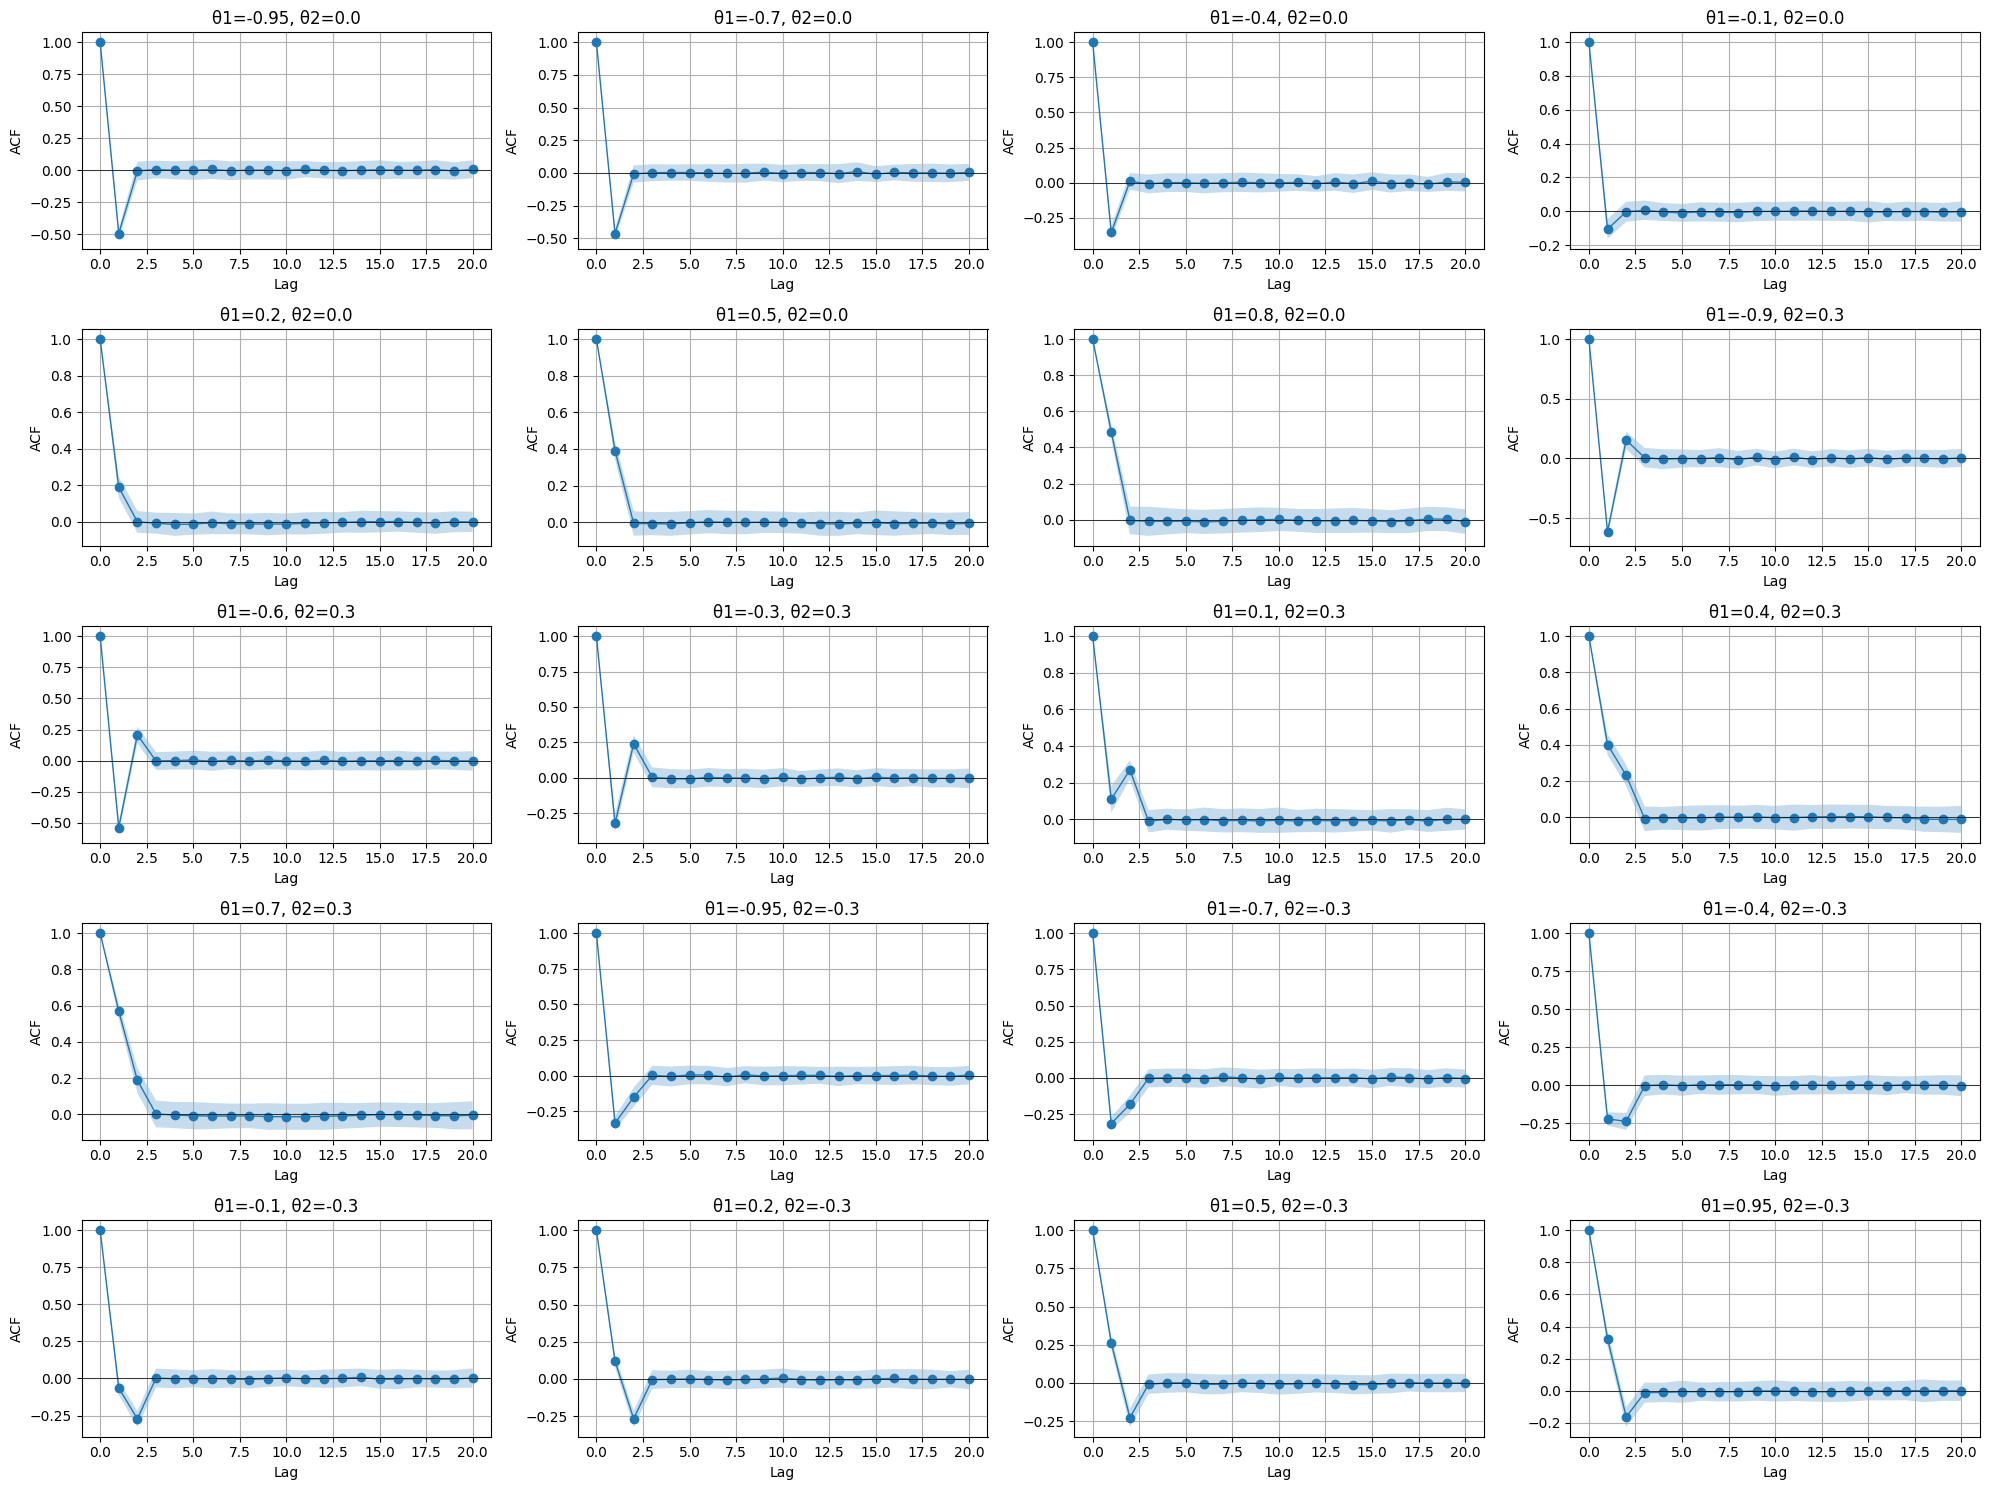

In [15]:
# -----------------------------------------------------------------------------------------------------------------------------------
# Ejemplos de visualización:
# 1) Para algunas combinaciones seleccionadas, graficar la ACF promedio con bandas ±1 std (visualiza la variabilidad entre réplicas).
# 2) Seleccionamos un subconjunto para no saturar la salida.
# ------------------------------------------------------------------------------------------------------------------------------------

# Elegimos un subconjunto representativo de pares para graficar
# Si la cantidad total de pares es pequeña podemos graficarlos todos.
pairs = df_results[['theta1', 'theta2']].values.tolist()
n_pairs = len(pairs)

# Definimos cuántos pares graficar como máximo (evitar montón de figuras). Queremos máximo 20 paneles (5x4)
n_rows, n_cols = 5, 4
max_plots = n_rows * n_cols

# Elegimos índices distribuidos uniformemente
plot_indices = np.linspace(0, n_pairs - 1, min(max_plots, n_pairs), dtype=int)

# Preparamos figura y axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 15))
axes = axes.flatten()  # para indexar fácilmente

# Graficamos ACF media ± std para los pares seleccionados
for ax_i, idx in enumerate(plot_indices):
    ax = axes[ax_i]

    row = df_results.iloc[idx]
    th1 = row['theta1']
    th2 = row['theta2']
    acf_mean = np.array(row['acf_mean_by_lag'])
    acf_std = np.array(row['acf_std_by_lag'])
    lags = np.arange(len(acf_mean))

    # Curva de ACF media
    ax.plot(lags, acf_mean, marker='o', linewidth=1)

    # Banda de ±1 desviación estándar
    ax.fill_between(
        lags,
        acf_mean - acf_std,
        acf_mean + acf_std,
        alpha=0.25
    )

    ax.axhline(0, color='k', linewidth=0.5)
    ax.set_title(f"θ1={th1}, θ2={th2}")
    ax.set_xlabel("Lag")
    ax.set_ylabel("ACF")
    ax.grid(True)

# Si sobran paneles, los apagamos
for j in range(len(plot_indices), max_plots):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

In [16]:
# ================================================================
# Función helper para leer datos de ticker desde CSV o descargarlos
# ================================================================

def read_ticker_csv(csv_file, ticker):
    """
    Función helper para leer datos de ticker desde CSV local o descargarlos desde Yahoo Finance.
    
    Esta función implementa un patrón de caché: primero intenta leer los datos desde un archivo
    CSV local. Si el archivo no existe o tiene formato inválido, descarga los datos desde Yahoo
    Finance y los guarda localmente para futuras ejecuciones.
    
    Parámetros:
    -----------
    csv_file : str
        Nombre del archivo CSV donde se guardarán/cargarán los datos.
        Ejemplo: "AAPL.csv"
    ticker : str
        Símbolo del ticker a descargar (ej: "AAPL", "MSFT", "SPY").
        Debe ser un símbolo válido de Yahoo Finance.
    
    Retorna:
    --------
    pd.DataFrame
        DataFrame con los datos del ticker, con las siguientes características:
        - Índice: fechas (DatetimeIndex) con nombre "Date"
        - Columnas: Open, High, Low, Close, Volume (estándar de Yahoo Finance)
        - Datos ajustados por splits y dividendos si auto_adjust=True
    
    Raises:
    -------
    ValueError
        Si el DataFrame descargado está vacío o no contiene la columna 'Close'
    
    Ejemplos:
    --------
    >>> df = read_ticker_csv("AAPL.csv", "AAPL")
    >>> df.head()
    
    Notas:
    ------
    - Los datos se descargan para el período 2020-01-01 a 2024-12-31
    - Los precios se ajustan automáticamente por splits y dividendos
    - El archivo CSV se guarda con el índice como columna "Date"
    """
    try:
        # Intento de lectura desde CSV local
        df = pd.read_csv(csv_file, index_col="Date", parse_dates=True)
        
        # Validación: verificar que el DataFrame no esté vacío
        if df.empty:
            raise ValueError(f"El archivo '{csv_file}' existe pero está vacío")
        
        # Validación: verificar que tenga la columna 'Close' necesaria para análisis
        if 'Close' not in df.columns:
            raise ValueError(f"El archivo '{csv_file}' no contiene la columna 'Close' requerida")
        
        print(f"Datos de {ticker} cargados desde '{csv_file}' ({len(df)} registros)")
        return df
        
    except (FileNotFoundError, KeyError, ValueError) as e:
        # Si no existe el archivo CSV o no tiene formato válido, descargamos desde Yahoo Finance
        if isinstance(e, FileNotFoundError):
            print(f"Archivo '{csv_file}' no encontrado. Descargando desde Yahoo Finance...")
        else:
            print(f"Archivo '{csv_file}' tiene formato inválido: {e}. Descargando desde Yahoo Finance...")
        
        df = yf.download(
            ticker,                    # Símbolo de la acción
            start="2020-01-01",        # Fecha de inicio
            end="2024-12-31",          # Fecha de fin
            auto_adjust=True           # Ajusta precios por splits y dividendos automáticamente
        )
        
        # Validación: verificar que la descarga fue exitosa
        if df.empty:
            raise ValueError(f"No se pudieron descargar datos para el ticker '{ticker}'. "
                           f"Verifica que el símbolo sea correcto.")
        
        if 'Close' not in df.columns:
            raise ValueError(f"Los datos descargados para '{ticker}' no contienen la columna 'Close'")
        
        # Aseguramos que el índice tenga el nombre "Date" para lectura posterior
        df.index.name = "Date"
        
        # Guardamos los datos descargados en CSV para futuras ejecuciones
        df.to_csv(csv_file)
        print(f"Datos de {ticker} descargados y guardados en '{csv_file}' ({len(df)} registros)")
        return df


#### Análisis estadístico de los resultados obtenidos

La simulación repitió 200 veces cada proceso $MA(2)$ con $n=300$ observaciones por serie, para los siguientes pares de parámetros:

En cada repetición se calculó:
* la media muestral
* la varianza muestral

Luego se promediaron estos valores a lo largo de las 200 simulaciones.

Los resultados finales fueron:

| θ₁   | θ₂   | mean(mean) | std(mean) | mean(var) | std(var) |
| ---- | ---- | ---------- | --------- | --------- | -------- |
| -0.5 | -0.3 | -0.000409  | 0.012632  | 1.343997  | 0.120501 |
| -0.5 | 0.3  | 0.002494   | 0.043904  | 1.325075  | 0.132814 |
| 0.5  | -0.3 | 0.001605   | 0.063878  | 1.328939  | 0.127068 |
| 0.5  | 0.3  | -0.008006  | 0.108349  | 1.322943  | 0.132141 |

1. ***Comportamiento de las medias***

Recordemos que para un proceso MA(2) sin término constante:

$$
X_{t} = \epsilon_{t} + \theta_{1}\epsilon_{t-1} + \theta_{2}\epsilon_{t-2}
$$

con $\epsilon_{t} \sim  N(0,1)$, la media teórica es cero.

* Resultados observados
    - En todos los casos, el promedio de las medias simuladas está extremadamente cerca de 0 (entre −0.008 y +0.002).
    - Esto indica que el estimador de la media es insesgado, como se esperaba.

* Variabilidad de las medias (`std(mean)`)
    - La variabilidad es más baja cuando  ($\theta_{1}$,$\theta_{2}$) son ambos negativos → $\sim 0.013$.
    - La variabilidad aumenta al introducir signos diferentes o valores positivos.
    - El caso más variable es $(0.5,0.3)$ → `std(mean)` $≈ 0.108$.

Interpretación: Ciertos parámetros producen procesos con más persistencia en la dependencia a corto plazo, lo que genera series con mayor variabilidad en sus medias entre simulaciones.

2. ***Comportamiento de la varianza***

La varianza teórica del proceso $MA(2)$ es:

$$
Var(X_{t}) = 1 + \theta_{1}^{2} + \theta_{2}^{2}
$$

Para todos los casos:

$$
1 + 0.5^{2} + 0.3^{2} = 1 + 0.25 + 0.09 = 1.34
$$

Resultados observados:

| θ₁         | θ₂         | var teórica | mean(var) simulada  |
| ---------- | ---------- | ----------- | ------------------- |
| cualquiera | cualquiera | 1.34        | entre 1.322 y 1.344 |


La coincidencia es excelente, con desviaciones de menos del 2%.

* Esto confirma:
    - la simulación está bien implementada,
    - el proceso estimado converge correctamente a la teoría,
    - el tamaño de muestra $n=300$ es suficiente para estimar bien la varianza.

* Variabilidad de la varianza (`std(var)`)
    - Los valores están entre 0.12 y 0.13, todos muy similares.

Interpretación: La estimación de la varianza es relativamente estable entre simulaciones, sin depender fuertemente de los signos o valores de $\theta_{1}$, $\theta_{2}$.

3. ***Efecto del signo de los parámetros***

El cambio más claro aparece en la variabilidad de la media (`std(mean)`):
* Cuando ambos parámetros son negativos, la serie parece más "equilibrada", con poca persistencia → menor varianza en las medias entre simulaciones.
* Cuando ambos parámetros son positivos → mayor acumulación de efectos → mayor variabilidad.

Esto es intuitivo: La estructura MA puede generar valores más extremados cuando los efectos de shocks previos se suman en el mismo sentido.

4. ***Conclusiones generales***

* Los resultados concuerdan perfectamente con la teoría $MA(2)$.
* Las medias son aproximadamente cero, como debe ser.
* La varianza simulada coincide con la varianza teórica:
$$
Var(X_{t}) = 1 + \theta_{1}^{2} + \theta_{2}^{2} = 1.34
$$
* Las diferencias más notables entre configuraciones se observan en:
    - la variabilidad en las medias, que es menor cuando los coeficientes son negativos,
    - ligeras diferencias en la variabilidad de la varianza, aunque mucho menores.
* En términos de estabilidad: El caso $(\theta_{1},\theta_{2})=(-0.5,-0.3)$ produce las series más estables (menor variación entre simulaciones).El caso $(-0.5,-0.3)$ produce la mayor variabilidad en las medias → proceso más sensible a los shocks.

#### Analisis gráficos de promedios

En lo que sigue, realizaremos un último análisis del modelo $MA(2)$
* ACF promedio por $\theta_{2}$: figura con muchas curvas (una por cada $\theta_{1}$).
    - Para un $MA(2)$ esperado, la ACF debe ser significativa en los lags 1 y 2 y cercana a 0 para lags > 2.
    - En las curvas promedio debe notarse esa caída brusca después del lag 2; la intensidad en lags 1 y 2 variará con $\theta_{1}$.
* PACF promedio por $\theta_{2}$: decaimiento gradual (no corte nítido), típico de $MA(q)$.
* Boxplots de medias por $\theta_{1}$ (para cada $\theta_{2}$): muestran la variabilidad entre réplicas de la media muestral.
    - Deben agruparse alrededor de 0.
* Boxplots de varianzas por $\theta_{1}$: muestran la variabilidad entre réplicas de la varianza.
    - La varianza teórica es $1 + \theta_{1}^{2} + \theta_{2}^{2} $.

In [17]:
# =======================================================================
# Simulaciones MA(2): ACF/PACF promedio y distribuciones de medias/varianzas
# =======================================================================

# -------------------------------------------------------
# Semilla y parámetros generales
# -------------------------------------------------------
np.random.seed(42)           # fija semilla para reproducibilidad
n = 300                      # longitud de cada serie simulada
n_sims = 200                 # réplicas por combinación (ajusta según tiempo)
max_lag = 20                 # máximo rezago para ACF/PACF

# -------------------------------------------------------
# Parrilla de parámetros a explorar
# -------------------------------------------------------
theta1_values = [-0.95, -0.9, -0.8, -0.7, -0.6,
                 -0.5, -0.4, -0.3, -0.2, -0.1,
                  0.0,  0.1,  0.2,  0.3,  0.4,
                  0.5,  0.6,  0.7,  0.8,  0.95]

theta2_values = [0.0, 0.3, -0.3]   # valores para theta2 que queremos comparar

# -------------------------------------------------------
# Estructura para almacenar resultados
# -------------------------------------------------------
# results[theta2][theta1] = dict con arrays y promedios
results = {}

# -------------------------------------------------------
# Bucle principal: por cada (theta2, theta1) simulamos n_sims series
# -------------------------------------------------------
for theta2 in theta2_values:
    # inicializamos sub-diccionario para este theta2
    results[theta2] = {}
    # iteramos sobre todos los theta1
    for theta1 in theta1_values:

        # --- pre-asignación de arrays para eficiencias ---
        means_rep = np.empty(n_sims)         # medias muestrales por réplica
        vars_rep = np.empty(n_sims)          # varianzas muestrales por réplica
        acf_accum = np.zeros(max_lag + 1)    # acumulador para sumar ACF (por lag)
        pacf_accum = np.zeros(max_lag + 1)   # acumulador para PACF

        # --- bucle de réplicas ---
        for sim in range(n_sims):
            # arma_generate_sample recibe:
            # ar = [1, -phi1, ...]  (phi=0 => ar=[1])
            # ma = [1, theta1, theta2, ...]
            ar = np.array([1])                         # sin parte AR
            ma = np.array([1, theta1, theta2])        # MA(2): [1, θ1, θ2]

            # generamos la serie de longitud n (ruido blanco interno)
            serie = arma_generate_sample(ar, ma, nsample=n)

            # calculamos estadísticas por réplica
            means_rep[sim] = serie.mean()             # media muestral de la réplica
            vars_rep[sim] = serie.var(ddof=1)         # varianza muestral (ddof=1)

            # calculamos ACF y PACF numéricos hasta max_lag (no gráficos)
            # acf(..., fft=False): más estable con series moderadas
            acf_vals = acf(serie, nlags=max_lag, fft=False)
            # pacf con método 'ld' (Levinson-Durbin) suele ser eficiente
            pacf_vals = pacf(serie, nlags=max_lag, method='ld')

            # acumulamos para calcular la media entre réplicas posteriormente
            acf_accum += acf_vals
            pacf_accum += pacf_vals

        # --- después de todas las réplicas calculamos promedios y desviaciones ---
        acf_mean = acf_accum / n_sims            # ACF promedio por lag
        pacf_mean = pacf_accum / n_sims          # PACF promedio por lag

        mean_of_means = means_rep.mean()         # media (entre réplicas) de las medias
        std_of_means = means_rep.std(ddof=1)     # std (entre réplicas) de las medias
        mean_of_vars = vars_rep.mean()           # media (entre réplicas) de las varianzas
        std_of_vars = vars_rep.std(ddof=1)       # std (entre réplicas) de las varianzas

        # --- almacenamos todo en el diccionario results ---
        results[theta2][theta1] = {
            'means_rep': means_rep,             # distribución completa de medias (n_sims)
            'vars_rep': vars_rep,               # idem varianzas
            'mean_of_means': mean_of_means,
            'std_of_means': std_of_means,
            'mean_of_vars': mean_of_vars,
            'std_of_vars': std_of_vars,
            'acf_mean': acf_mean,               # vector (lags 0..max_lag)
            'pacf_mean': pacf_mean
        }

# -------------------------------------------------------
# Construcción de un DataFrame resumen para inspección rápida
# -------------------------------------------------------
summary_rows = []
for theta2 in theta2_values:
    for theta1 in theta1_values:
        r = results[theta2][theta1]
        summary_rows.append({
            'theta2': theta2,
            'theta1': theta1,
            'mean_of_means': r['mean_of_means'],
            'std_of_means': r['std_of_means'],
            'mean_of_vars': r['mean_of_vars'],
            'std_of_vars': r['std_of_vars']
        })
df_summary = pd.DataFrame(summary_rows)

In [18]:
(
    df_summary
    .head(10)
    .style
    .format(precision=4)
    .set_caption("Resumen de simulaciones MA(2) – primeras 10 combinaciones")
)


Veamos las gráficas. Primero analicemos el ACF promedio.

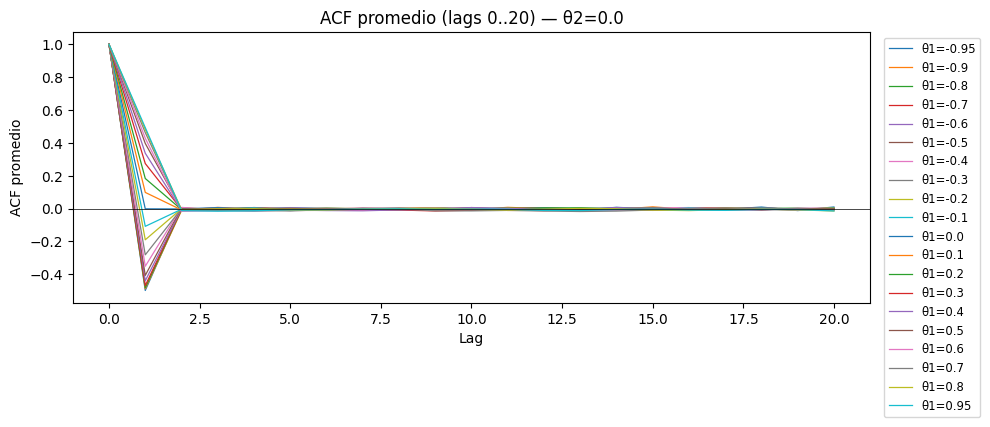

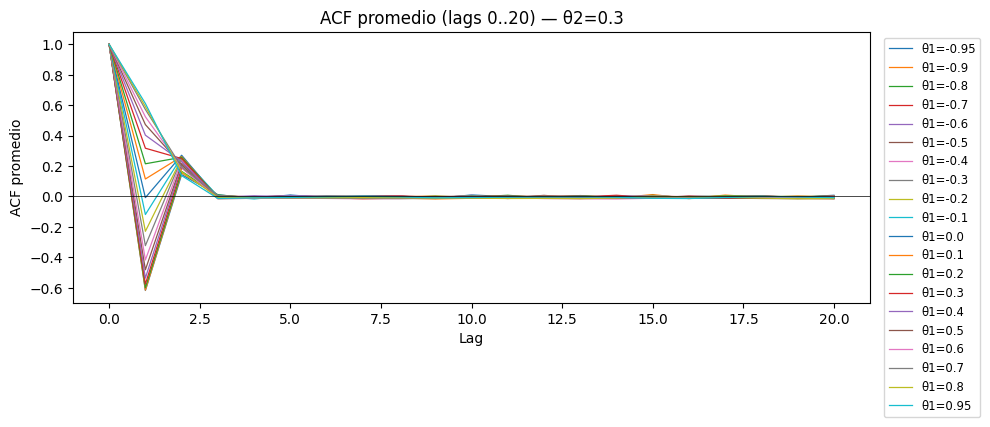

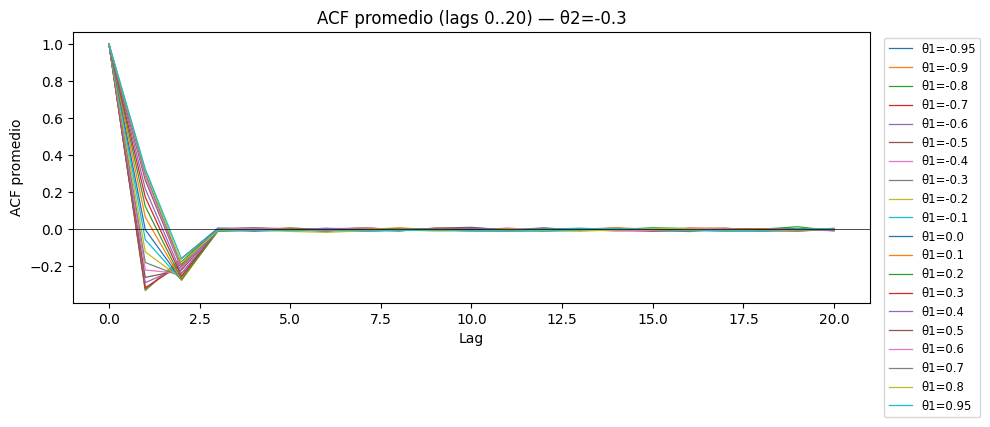

In [19]:
# ==============================================
# GRÁFICOS (ACF/PACF promedio y distribuciones)
# ==============================================

# 1) Para cada theta2 mostramos ACF promedio (superponemos curvas de distintos theta1)
lags = np.arange(max_lag + 1)
for theta2 in theta2_values:
    plt.figure(figsize=(10, 4))
    # superponemos la ACF media para cada theta1
    for theta1 in theta1_values:
        plt.plot(lags, results[theta2][theta1]['acf_mean'], label=f"θ1={theta1}", linewidth=0.9)
    plt.title(f"ACF promedio (lags 0..{max_lag}) — θ2={theta2}")
    plt.xlabel("Lag"); plt.ylabel("ACF promedio")
    plt.axhline(0, color='k', linewidth=0.5)
    plt.legend(bbox_to_anchor=(1.01,1), loc='upper left', fontsize='small', ncol=1)
    plt.tight_layout()
    plt.show()

Luego, grafiquemos el PCAF promedio.

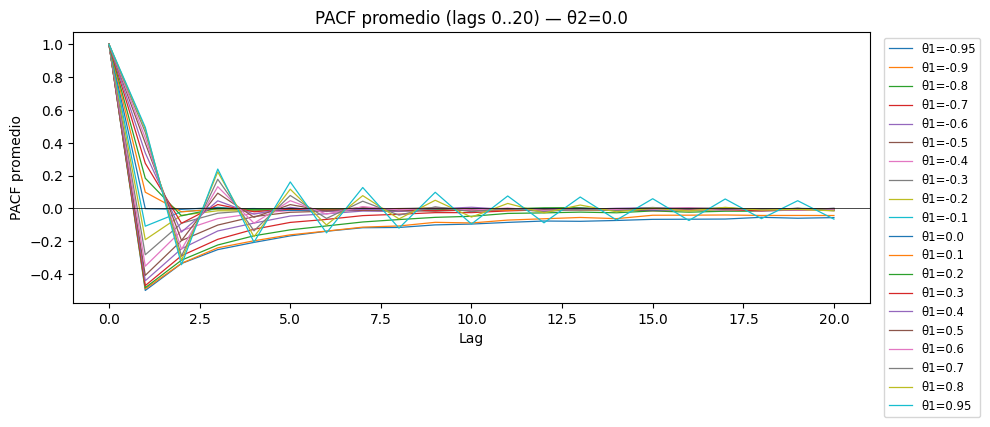

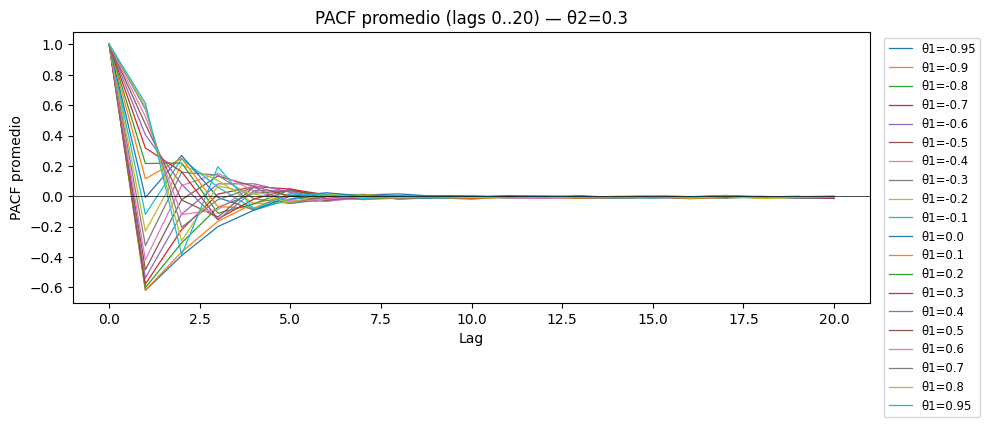

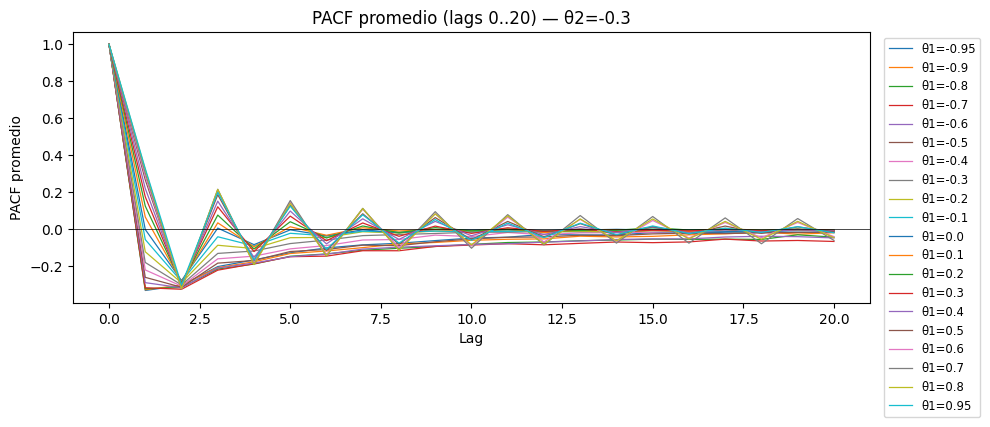

In [20]:
# 2) PACF promedio (idem)
for theta2 in theta2_values:
    plt.figure(figsize=(10, 4))
    for theta1 in theta1_values:
        plt.plot(lags, results[theta2][theta1]['pacf_mean'], label=f"θ1={theta1}", linewidth=0.9)
    plt.title(f"PACF promedio (lags 0..{max_lag}) — θ2={theta2}")
    plt.xlabel("Lag")
    plt.ylabel("PACF promedio")
    plt.axhline(0, color='k', linewidth=0.5)
    plt.legend(bbox_to_anchor=(1.01,1), loc='upper left', fontsize='small', ncol=1)
    plt.tight_layout()
    plt.show()

Por último, las distribuciones de las medias y las variancias.

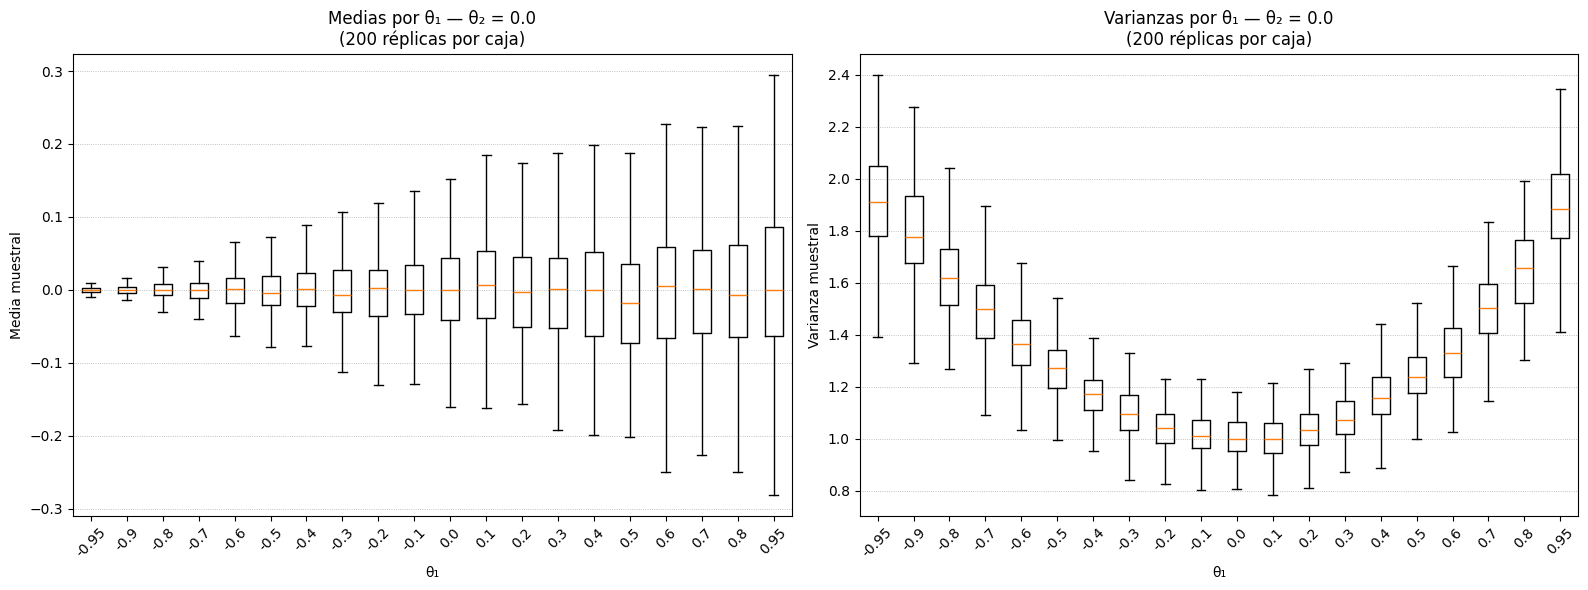

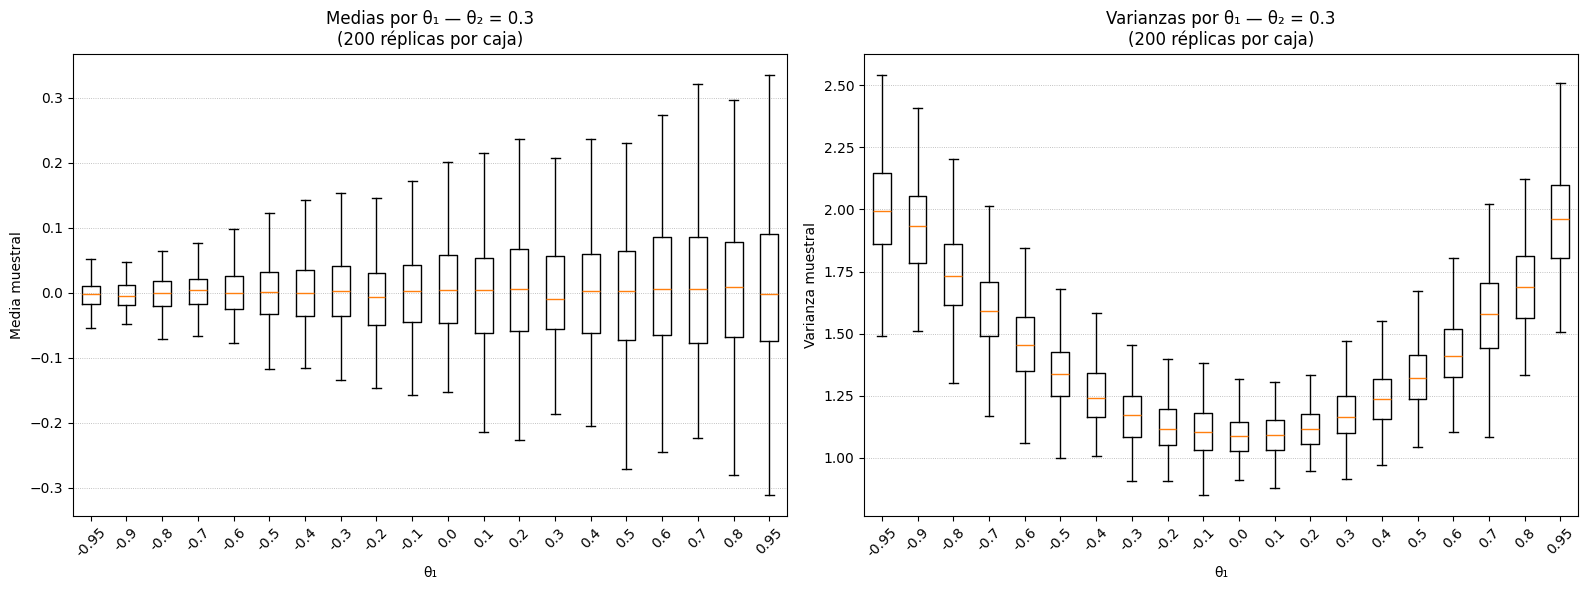

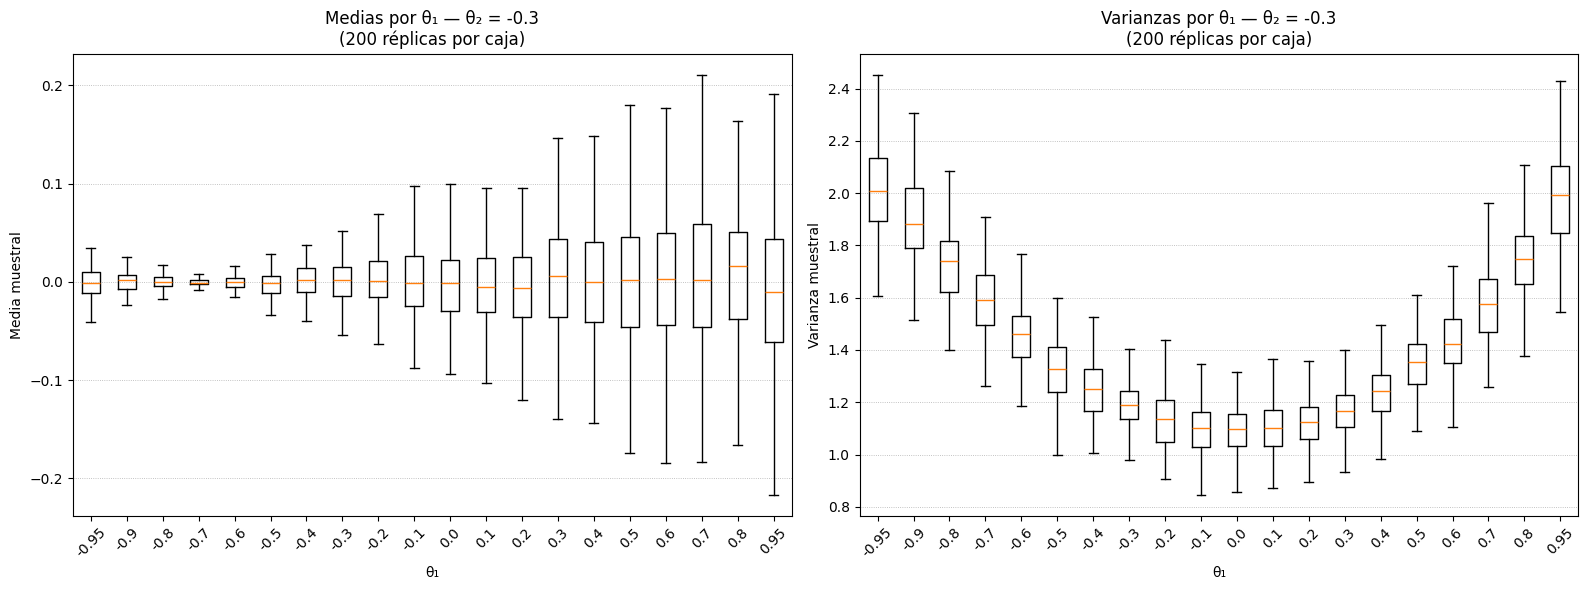

In [21]:
# 3) Distribuciones de medias y varianzas
# Para cada theta2: boxplot de medias (una caja por theta1) y boxplot de varianzas
for theta2 in theta2_values:
    # ------------------------------------------------------------
    # Construimos las matrices de tamaño (num_theta1 × n_sims)
    # ------------------------------------------------------------
    means_matrix = np.vstack([results[theta2][t1]['means_rep'] for t1 in theta1_values])
    vars_matrix  = np.vstack([results[theta2][t1]['vars_rep']  for t1 in theta1_values])

    # ------------------------------------------------------------
    # Creamos una figura con 1 fila y 2 columnas
    # ------------------------------------------------------------
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # ------------------------------------------------------------
    # Subplot 1 — Boxplot de medias
    # ------------------------------------------------------------
    axes[0].boxplot(
        means_matrix.T,
        tick_labels=[str(t) for t in theta1_values],
        showfliers=False
    )
    axes[0].set_title(f"Medias por θ₁ — θ₂ = {theta2}\n({n_sims} réplicas por caja)")
    axes[0].set_xlabel("θ₁")
    axes[0].set_ylabel("Media muestral")
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(True, axis='y', linestyle=':', linewidth=0.6)

    # ------------------------------------------------------------
    # Subplot 2 — Boxplot de varianzas
    # ------------------------------------------------------------
    axes[1].boxplot(
        vars_matrix.T,
        tick_labels=[str(t) for t in theta1_values],
        showfliers=False
    )
    axes[1].set_title(f"Varianzas por θ₁ — θ₂ = {theta2}\n({n_sims} réplicas por caja)")
    axes[1].set_xlabel("θ₁")
    axes[1].set_ylabel("Varianza muestral")
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(True, axis='y', linestyle=':', linewidth=0.6)

    # ------------------------------------------------------------
    # Ajustamos la figura completa
    # ------------------------------------------------------------
    plt.tight_layout()
    plt.show()

### Modelo ARMA(2,1)

En lo que sigue, analizaremos la serie temporal ***ARMA(2,1)*** gráficamente y lo compararemos con el modelo $MA(2)$.

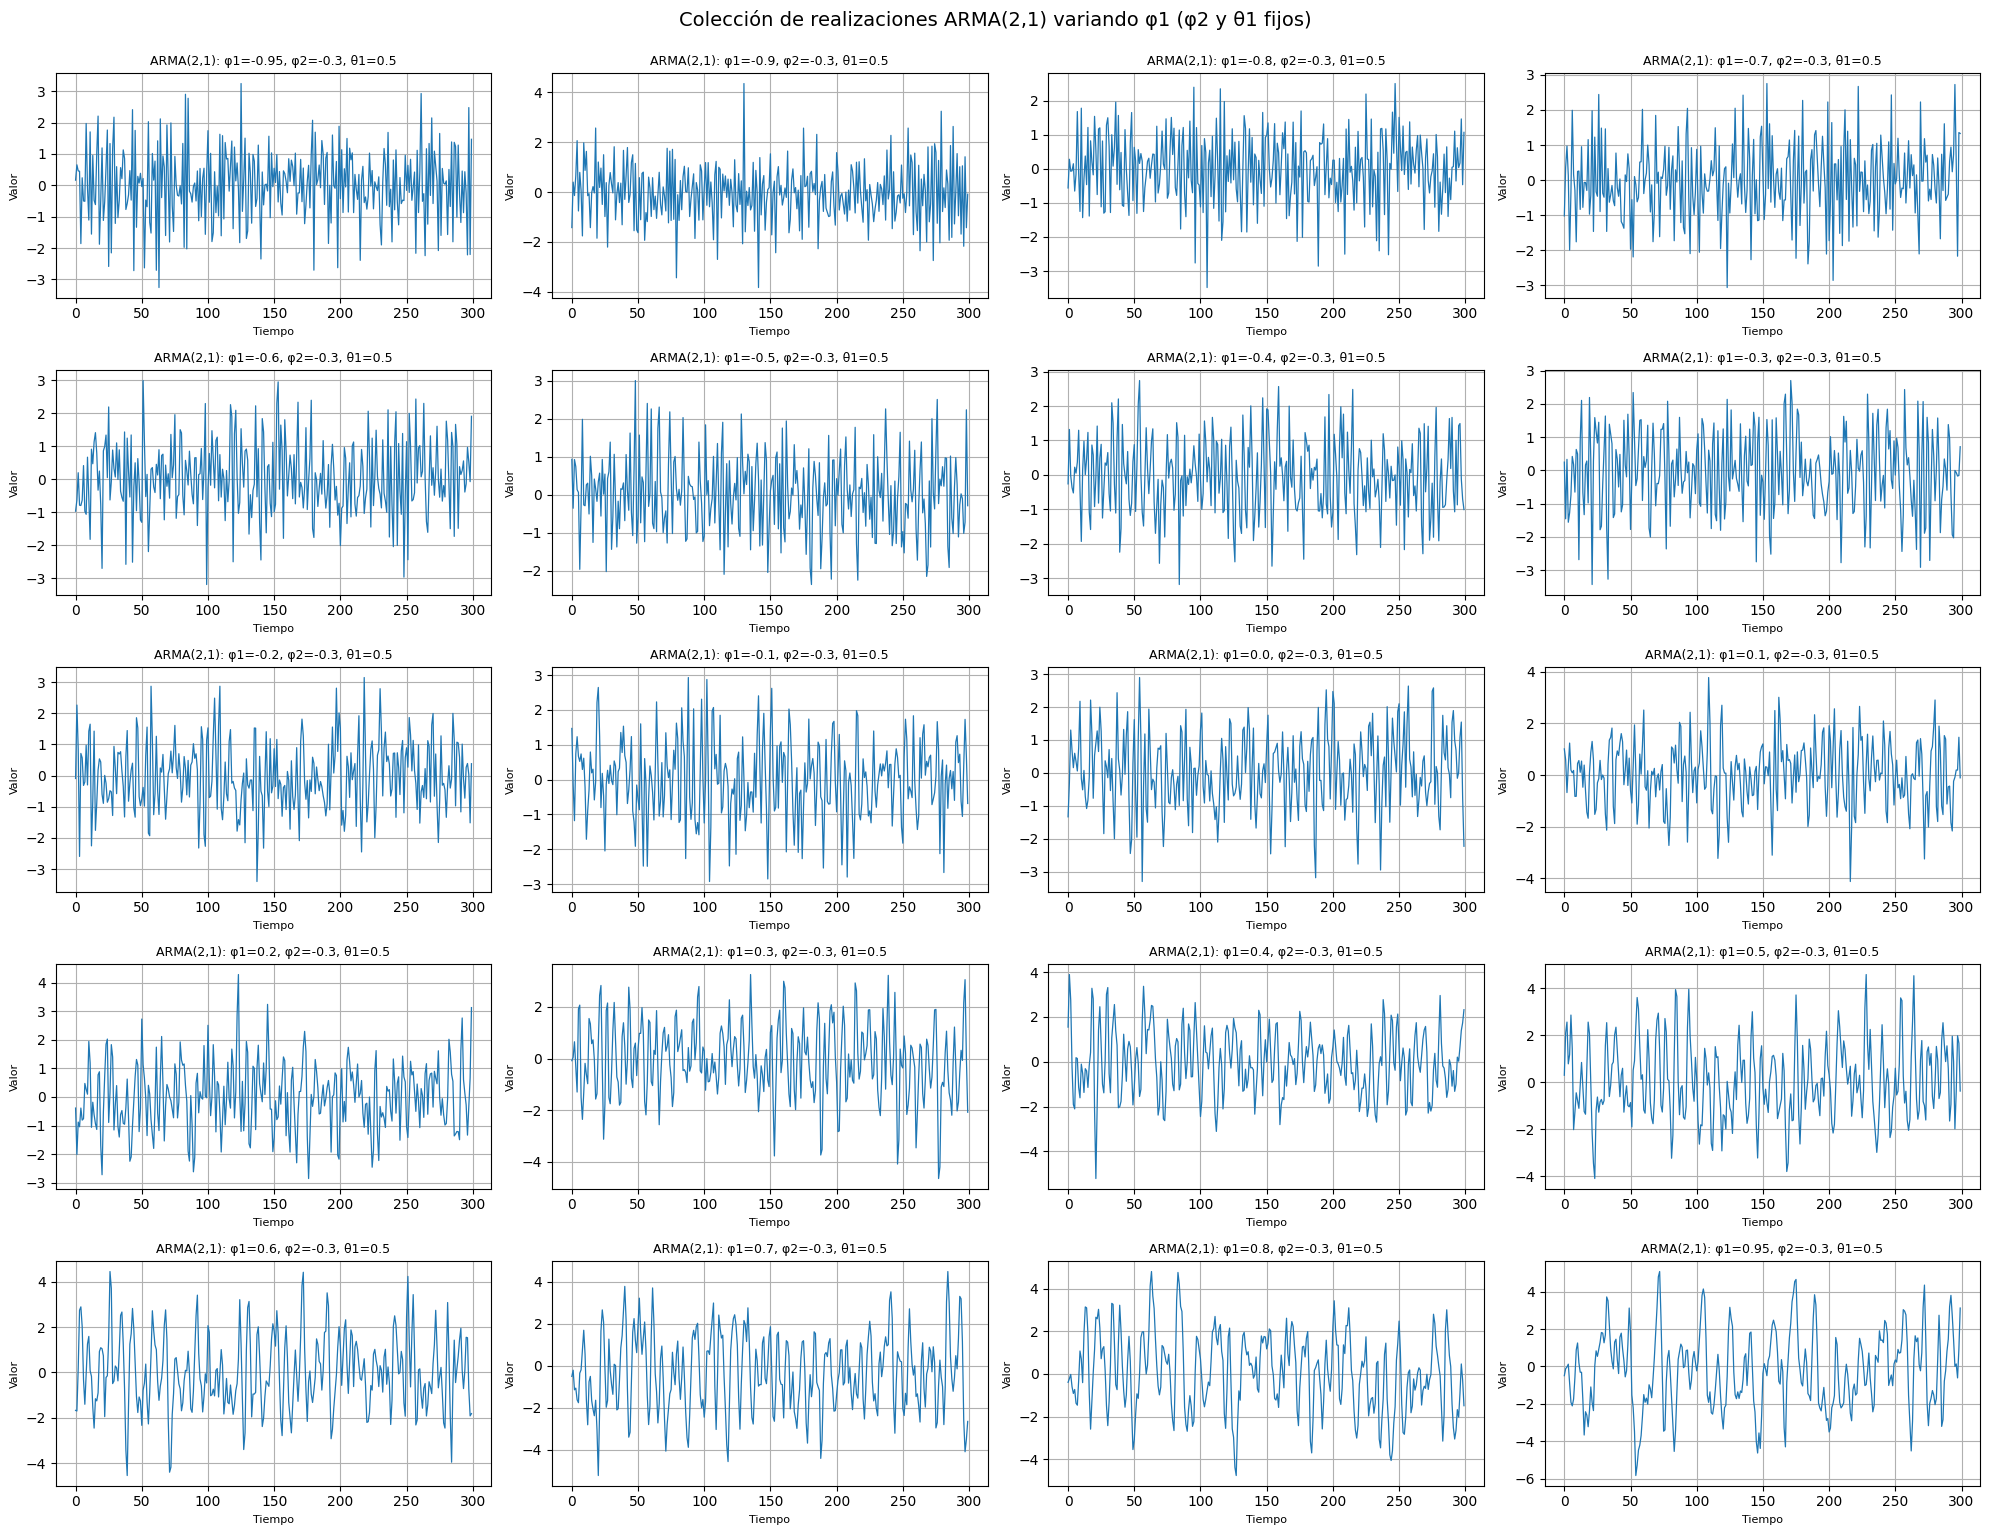

In [22]:
# ===============================================================
# Generación y comparación: ARMA(2,1) vs MA(2)
# ===============================================================

# ------------------------------------------------------------
# Parámetros generales de la simulación
# ------------------------------------------------------------
n = 300                # número de observaciones por serie (igual que en ejercicios anteriores)
# Definimos una lista de valores para variar el primer coeficiente AR (análogo a a1_values)
phi1_values = [-0.95, -0.9, -0.8, -0.7, -0.6,
               -0.5, -0.4, -0.3, -0.2, -0.1,
                0.0,  0.1,  0.2,  0.3,  0.4,
                0.5,  0.6,  0.7,  0.8,  0.95]

# ------------------------------------------------------------
# Elegimos valores fijos para el segundo coeficiente AR y para el término MA(1)
# Estos valores son solo ilustrativos: los podés cambiar si querés explorar.
# ------------------------------------------------------------
phi2 = -0.3     # coeficiente AR(2) fijo (puede ser negativo para introducir oscilaciones)
theta1 = 0.5    # coeficiente MA(1) fijo para la parte MA del ARMA(2,1)

# ------------------------------------------------------------
# PARTE A: Generación y graficación de varias realizaciones ARMA(2,1)
# Queremos una grilla de 5 x 4 (20 paneles) igual que en tu ejemplo
# ------------------------------------------------------------
n_rows, n_cols = 5, 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 15))
axes = axes.flatten()   # convierte la matriz 2D de ejes en un vector 1D para indexar con i

# Bucle que recorre phi1_values y genera una serie ARMA(2,1) por cada phi1
for i, phi1 in enumerate(phi1_values):

    # ------------------------------------------------------------
    # Definimos los vectores ar y ma en el formato que espera arma_generate_sample:
    #   - ar = [1, -phi1, -phi2]   (se ingresan los AR con signo negativo)
    #   - ma = [1, theta1]         (coeficientes MA con signo "normal")
    # ------------------------------------------------------------
    ar_params = np.array([1, -phi1, -phi2])   # vector AR para ARMA(2,1)
    ma_params = np.array([1, theta1])         # vector MA con un término

    # ------------------------------------------------------------
    # Generamos la serie con arma_generate_sample:
    # nsample = n es la longitud de la serie
    # arma_generate_sample genera ruido blanco internamente y aplica
    # los filtros AR/MA definidos por ar_params y ma_params.
    # ------------------------------------------------------------
    serie_arma21 = arma_generate_sample(ar_params, ma_params, nsample=n)

    # ------------------------------------------------------------
    # Seleccionamos el subplot correspondiente y graficamos la serie
    # ------------------------------------------------------------
    ax = axes[i]
    ax.plot(serie_arma21, color='tab:blue', linewidth=0.9)  # dibuja la serie
    ax.set_title(f"ARMA(2,1): φ1={phi1}, φ2={phi2}, θ1={theta1}", fontsize=9)
    ax.set_xlabel("Tiempo", fontsize=8)
    ax.set_ylabel("Valor", fontsize=8)
    ax.grid(True)

# Si hay ejes extra (no usados) los apagamos por estética
for j in range(len(phi1_values), n_rows * n_cols):
    axes[j].axis('off')

plt.tight_layout()
plt.suptitle("Colección de realizaciones ARMA(2,1) variando φ1 (φ2 y θ1 fijos)", y=1.02, fontsize=14)
plt.show()

En lo que sigue, repasemos un ejemplo de modelo $MA(2)$

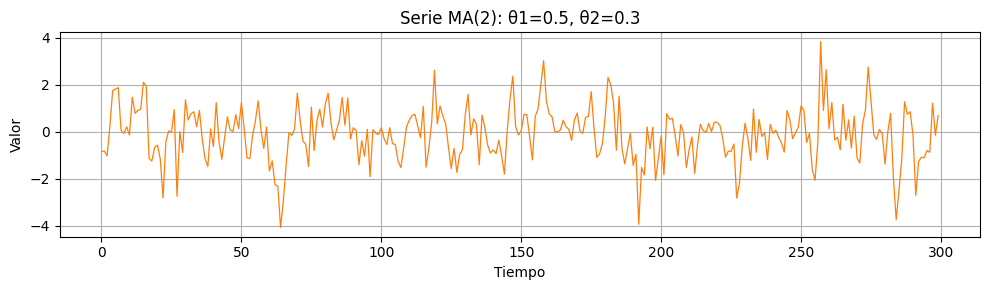

In [23]:
# ------------------------------------------------------------
# PARTE B: Generación de una serie MA(2) para comparación directa
# ------------------------------------------------------------
# Elegimos parámetros representativos para MA(2) (ejemplo)
theta1_ma2 = 0.5
theta2_ma2 = 0.3

# El vector MA para arma_generate_sample es [1, theta1, theta2]
ma2_params = np.array([1, theta1_ma2, theta2_ma2])

# AR para MA puro es [1] (no hay componente AR)
ar0 = np.array([1])

# Generamos la serie MA(2)
serie_ma2 = arma_generate_sample(ar0, ma2_params, nsample=n)

# Graficamos la serie MA(2) en una figura aparte
plt.figure(figsize=(10, 3))
plt.plot(serie_ma2, color='tab:orange', linewidth=0.9)
plt.title(f"Serie MA(2): θ1={theta1_ma2}, θ2={theta2_ma2}")
plt.xlabel("Tiempo")
plt.ylabel("Valor")
plt.grid(True)
plt.tight_layout()
plt.show()

Entonces, lo que podemos hacer a continuación es una comparación AFC y DAFC entre las diferentes series.

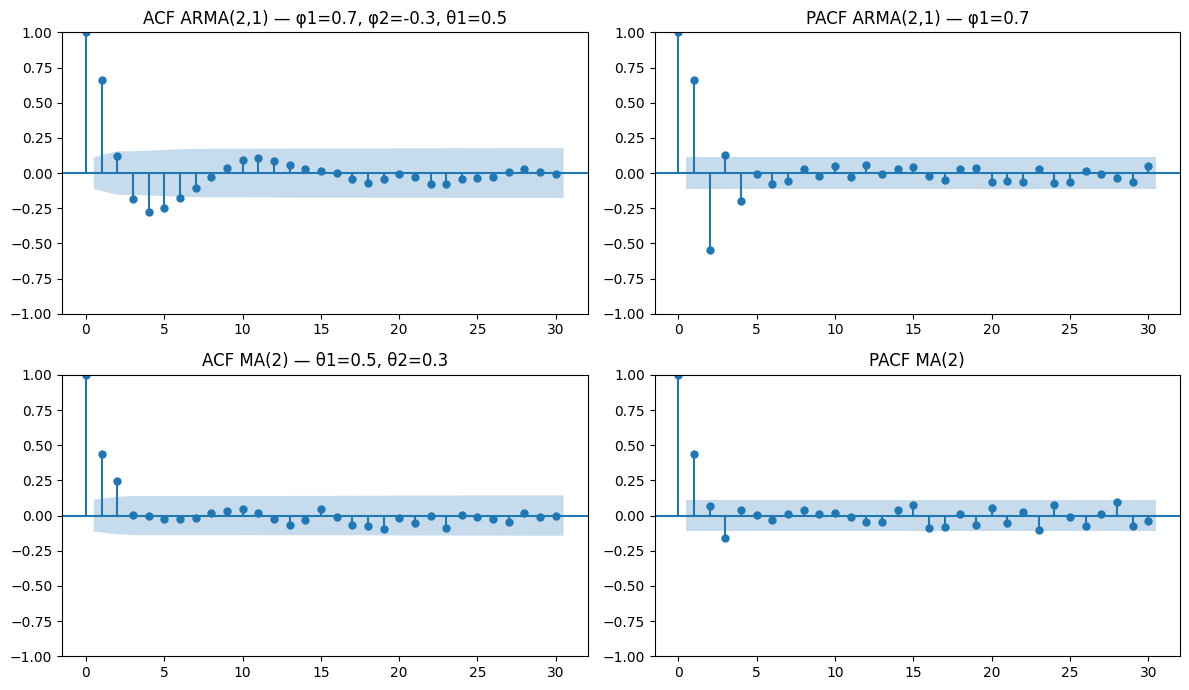

In [24]:
# ----------------------------------------------------------------------------------------
# PARTE C: ACF y PACF comparativos (una realización representativa de ARMA(2,1) vs MA(2))
# ----------------------------------------------------------------------------------------
# Seleccionamos una realización representativa de ARMA(2,1) (por ejemplo φ1 = 0.7)
phi1_rep = 0.7
ar_rep = np.array([1, -phi1_rep, -phi2])
ma_rep = np.array([1, theta1])
serie_rep = arma_generate_sample(ar_rep, ma_rep, nsample=n)

# Creamos figura con 2 filas y 2 columnas:
#   fila 1: ACF(ARMA) | PACF(ARMA)
#   fila 2: ACF(MA2)  | PACF(MA2)
fig2, axes2 = plt.subplots(2, 2, figsize=(12, 7))
axes2 = axes2.flatten()

# ACF y PACF de la realización ARMA(2,1)
plot_acf(serie_rep, lags=30, ax=axes2[0], title=f"ACF ARMA(2,1) — φ1={phi1_rep}, φ2={phi2}, θ1={theta1}")
plot_pacf(serie_rep, lags=30, ax=axes2[1], title=f"PACF ARMA(2,1) — φ1={phi1_rep}")

# ACF y PACF de la realización MA(2)
plot_acf(serie_ma2, lags=30, ax=axes2[2], title=f"ACF MA(2) — θ1={theta1_ma2}, θ2={theta2_ma2}")
plot_pacf(serie_ma2, lags=30, ax=axes2[3], title="PACF MA(2)")

plt.tight_layout()
plt.show()

#### Análisis de la comparacion entre ARMA(2,1) y MA(2)

A continuación analizaremos las series generadas y la comparación ACF/PACF entre un $ARMA(2,1)$ (con los parámetros elegidos) y un $MA(2)$.

1. ***Comportamiento temporal de las series (visual)***
* $ARMA(2,1)$:
    - La componente $AR(2)$ ($\phi_{1}$, $\phi_{2}$) gobierna la memoria y las posibles oscilaciones o suavidad de la serie.
    - Con $\phi_{1}$ positivo y $\phi_{2}$ negativo (como en el ejemplo $\phi_{2}$ = −0.3), es común obtener decaimiento con oscilaciones amortiguadas — es decir, alternancia de signos en la serie con amplitud que va decreciendo.
    - El término $MA(1)$ ($\theta_{1} = 0.5$) añade respuesta inmediata a choques pasados (ruido), haciendo la serie algo menos "limpia" que un AR puro.
* $MA(2)$:
    - Es una serie con dependencia a corto plazo: cada observación es combinación lineal de choques actuales y los dos anteriores.
    - Visualmente suele verse más "localmente correlacionada" en lags cortos, pero sin la larga memoria que un AR con coeficientes cercanos a 1 puede mostrar.
2. ***ACF (autocorrelación)***

* $MA(2)$:(modelo puro MA con $q=2$):
    - ACF corta después del lag 2: es decir, en teoría la ACF será distinta de cero (significativa) para lags 1 y 2, y aproximadamente 0 para lags > 2 (salvo ruido muestral).
* $ARMA(2,1)$:
    - ACF no corta abruptamente: decae de forma gradual (exponencial o oscilatoria según los signos de $\phi_{1}$/$\phi_{2}$).
    - La componente $MA(1)$ puede "distorsionar" la forma de la ACF en los primeros lags, pero la cola de la ACF la domina la parte AR.
    - Por tanto, si vemos una ACF que decae pero NO corta en lag 2, debemos sospechar AR o ARMA.
3. ***PACF (autocorrelación parcial)***
* $MA(2)$:
    - La PACF decae gradualmente; no corta en lag $q$ (esa propiedad es propia de ACF para MA). Por eso la PACF de un MA se ve como una cola decreciente/no nula.
* $ARMA(2,1)$:
    - Para un $AR(2)$ puro la PACF corta en lag 2 (valores significativos en lags 1 y 2, luego aproximadamente 0).
    - En $ARMA(2,1)$, la PACF generalmente seguirá mostrando picos en los primeros dos rezagos ($p=2$) porque la parte AR es de orden 2; el componente $MA(1)$ altera ligeramente las alturas, pero no cambia el corte teórico en $p$ (en promedio).
4. ***Identificación práctica (regla mnemotécnica)***
* Si ACF corta en $q$ y PACF decae → $MA(q)$.
* Si PACF corta en $p$ y ACF decae → $AR(p)$.
* Si ninguna corta nítidamente → debemos probar $ARMA(p,q)$ o revisar mezcla de términos.

Aplicado a nuestras simulaciones concretas:

* La serie $MA(2)$ que generamos (`theta1_ma2=0.5`, `theta2_ma2=0.3`) muestran ACF con picos en lags 1 y 2 y luego cerca de 0; la PACF muestra un decaimiento.
* La serie $ARMA(2,1)$ (ej. $\phi_{1}=0.7$, $\phi_{2}=-03$, $\theta_{1} = 0.5$) muestra PACF con picos en lag 1 y 2 (corte teórico en 2) y ACF con decaimiento (posiblemente oscilatorio por $\phi_{2}$ negativo), pero con alguna distorsión en lag 1 por el $\theta_{1}$.

A continuación, analizaremos la diferencia cuantitativa entre ACF/PACF (por ejemplo, norma de la cola) para decidir si una serie parece $MA(2)$ o $ARMA(2,1)$. Primero, debemos definir algunas funciones de utilidad.

In [25]:
# -------------------------------------------------------
# Función que calcula métricas y clasifica una sola serie
# -------------------------------------------------------
def classify_series(serie, q_ma=2, p_ar=2, nlags=30, thresh_low=0.5, thresh_high=2.0):
    """
    - serie: vector de datos
    - q_ma, p_ar: órdenes de referencia (q=2 para MA(2), p=2 para AR(2))
    - nlags: cuántos lags calcular
    - thresh_low / thresh_high: umbrales para la heurística
    Devuelve dict con normas de cola, ratio y etiqueta.
    """
    # calculamos ACF y PACF numéricos
    acf_vals = acf(serie, nlags=nlags, fft=False)          # ACF numérica
    pacf_vals = pacf(serie, nlags=nlags, method='ld')      # PACF por Levinson-Durbin

    # extraemos la "cola": lags estrictamente mayores que q_ma / p_ar
    acf_tail = acf_vals[(q_ma+1):]    # p. ej. si q_ma=2, tomamos lags 3..nlags
    pacf_tail = pacf_vals[(p_ar+1):]

    # norma L2 (energía) de las colas: medida de cuánta dependencia queda lejos
    acf_tail_norm = np.linalg.norm(acf_tail, ord=2)
    pacf_tail_norm = np.linalg.norm(pacf_tail, ord=2)

    # razón para comparar magnitudes relativas (evitamos división por cero)
    eps = 1e-12
    ratio = acf_tail_norm / (pacf_tail_norm + eps)

    # regla heurística: umbrales ajustables
    if ratio < thresh_low:
        label = f"MA(q={q_ma})-like"
    elif ratio > thresh_high:
        label = f"AR(p={p_ar})-like"
    else:
        label = "ARMA-like (ambiguous)"

    return {
        'acf_tail_norm': acf_tail_norm,
        'pacf_tail_norm': pacf_tail_norm,
        'ratio': ratio,
        'label': label,
        'acf_vals': acf_vals,
        'pacf_vals': pacf_vals
    }

# -------------------------------------------------------
# Función que evalúa un modelo repetidas veces y resume resultados
# -------------------------------------------------------
def evaluate_model(ar_params, ma_params, name, n_sims=80):
    records = []
    for sim in range(n_sims):
        # simulamos una realización
        serie = arma_generate_sample(ar_params, ma_params, nsample=n)
        # calculamos métricas y etiqueta
        rec = classify_series(serie, q_ma=2, p_ar=2, nlags=nlags)
        records.append(rec)
    # lo pasamos a DataFrame para resumir
    df = pd.DataFrame(records)
    counts = df['label'].value_counts(normalize=True)  # proporción por etiqueta
    summary = {
        'model': name,
        'n_sims': n_sims,
        'mean_acf_tail_norm': df['acf_tail_norm'].mean(),
        'std_acf_tail_norm': df['acf_tail_norm'].std(ddof=1),
        'mean_pacf_tail_norm': df['pacf_tail_norm'].mean(),
        'std_pacf_tail_norm': df['pacf_tail_norm'].std(ddof=1),
        'mean_ratio': df['ratio'].mean(),
        'std_ratio': df['ratio'].std(ddof=1),
        'label_counts': counts.to_dict()
    }
    return df, summary

Luego, realizamos la clasificación.

In [26]:
# ---------------------------------------------
# Clasificación heurística: MA(2) vs ARMA(2,1)
# ---------------------------------------------
#  - simula series (ARMA(2,1), MA(2), AR(2) de control)
#  - calcula ACF y PACF hasta nlags
#  - obtiene 'norma de cola' (L2) de ACF más allá de q=2 y de PACF más allá de p=2
#  - construye una razón (ratio = acf_tail_norm / pacf_tail_norm)
#  - aplica una regla heurística sobre la ratio para etiquetar la serie:
#      ratio < thresh_low  => "MA-like"
#      ratio > thresh_high => "AR-like"
#      else                => "ARMA-like (ambiguous)"
# --------------------------------------------

# -------------------------------------------------------
# Configuración reproducible y parámetros
# -------------------------------------------------------
np.random.seed(42)       # semilla para reproducibilidad
n = 300                  # longitud de cada serie simulada
n_sims = 80              # número de réplicas por modelo (ajustado para ejecución rápida)
nlags = 30               # número de lags para ACF/PACF

# -------------------------------------------------------
# Parámetros para los modelos que vamos a simular
# -------------------------------------------------------
# ARMA(2,1) ejemplo
phi1 = 0.7; phi2 = -0.3; theta1 = 0.5
ar_arma21 = np.array([1, -phi1, -phi2])
ma_arma21 = np.array([1, theta1])

# MA(2) ejemplo
theta1_ma2 = 0.5; theta2_ma2 = 0.3
ar_ma2 = np.array([1])
ma_ma2 = np.array([1, theta1_ma2, theta2_ma2])

# AR(2) de control (sin MA)
ar_ar2 = np.array([1, -phi1, -phi2])
ma_ar2 = np.array([1])

# -------------------------------------------------------
# Ejecutamos la evaluación para los tres modelos de ejemplo
# -------------------------------------------------------
df_arma21, summary_arma21 = evaluate_model(ar_arma21, ma_arma21, "ARMA(2,1)", n_sims=n_sims)
df_ma2, summary_ma2 = evaluate_model(ar_ma2, ma_ma2, "MA(2)", n_sims=n_sims)
df_ar2, summary_ar2 = evaluate_model(ar_ar2, ma_ar2, "AR(2) control", n_sims=n_sims)


# -------------------------------------------------------
summaries = pd.DataFrame([summary_arma21, summary_ma2, summary_ar2])


In [27]:
(
    summaries[[
        'model',
        'n_sims',
        'mean_acf_tail_norm',
        'std_acf_tail_norm',
        'mean_pacf_tail_norm',
        'std_pacf_tail_norm',
        'mean_ratio',
        'std_ratio'
    ]]
    .style
    .format(precision=4)
)


***Resultados numéricos (resumen)***

En la ejecución se obtuvo (valores redondeados):
* $ARMA(2,1)$

    - `mean_acf_tail_norm ≈ 0.444`
    - `mean_pacf_tail_norm ≈ 0.425`
    - `mean_ratio ≈ 1.05`
    
     clasificación mayoritaria: *ARMA-like* (ambiguous) 
     (100% en mi corrida con umbrales actuales)
* $MA(2)$

    - `mean_acf_tail_norm ≈ 0.384`
    - `mean_pacf_tail_norm ≈ 0.357`
    - `mean_ratio ≈ 1.08`
        
    clasificación mayoritaria: *ARMA-like* (ambiguous)
* $AR(2)$ control

    - `mean_acf_tail_norm ≈ 0.398`
    - `mean_pacf_tail_norm ≈ 0.322`
    - `mean_ratio ≈ 1.24`
    
    clasificación mayoritaria: *ARMA-like* (ambiguous)

En resumen: las normas de cola de ACF y PACF fueron de magnitud similar entre los modelos, y la regla heurística con los umbrales estándar (`thresh_low=0.5`, `thresh_high=2.0`) etiquetó la mayoría de las realizaciones como "ARMA-like (ambiguous)" — es decir, no hay una separación clara y contundente con esta métrica simple.

***Interpretación***

* Finite-sample & ruido muestral

    - En muestras de longitud n=300, la estimación empírica de ACF/PACF tiene variabilidad. Aunque teóricamente $MA(2)$ y $ARMA(2,1)$ tienen estructuras distintas, en realizaciones finitas la energía en las colas puede quedar parecida, especialmente cuando los parámetros ($\theta$ y $\phi$) no son extremos.
* Elección de métricas

    - Usar la norma L2 de la cola es razonable pero no siempre discriminante. Si la energía de la cola (lags > 2) es similar en ambos tipos de modelo, la ratio estará cerca de 1 ⇒ ambigüedad.
    - Además, la componente $MA(1)$ en $ARMA(2,1)$ altera la ACF en los primeros lags, lo que puede compensar en parte la cola, haciéndola parecida a la de un $MA(2)$ en magnitud.
* Umbrales heurísticos

    - Los umbrales 0.5 y 2.0 son relativamente amplios; si la ratio ronda 1, la decisión cae en el rango intermedio (ambiguous). Ajustar umbrales podría forzar decisiones, pero aumentaría riesgo de falsos positivos.

***Conclusiones prácticas***

* La heurística $L2$-tail es útil como indicador rápido, pero no es suficiente por sí sola para decidir entre $MA(2)$ y $ARMA(2,1)$ en muestras típicas ($n ≈ 300$), al menos con parámetros moderados.
* Todas las series resultaron ambiguas con la regla por defecto, lo que es una señal honesta de que la separación no es trivial con este enfoque.

## 2. ACF y PACF

En lo que sigue, consideremos el siguiente código de la función autocorrelación y la función de autocorrelación parcial.

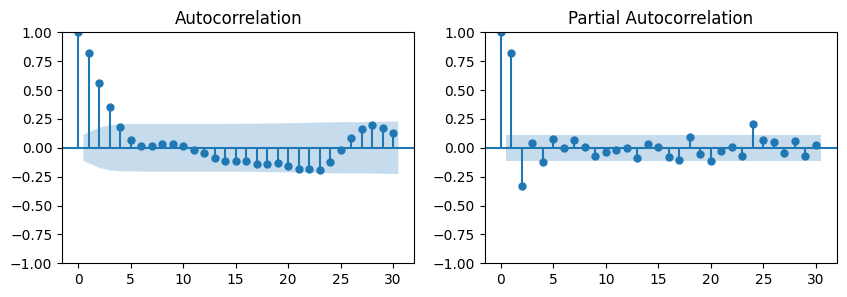

In [28]:
# ============================================================
#   Cálculo y visualización de la ACF y PACF de una serie ARMA
# ============================================================

# ------------------------------------------------------------
# Creamos una figura con 2 gráficos (subplots) dispuestos en 1 fila
# y 2 columnas. El tamaño total de la figura es de 10x3 pulgadas.
#
# fig    : variable que contiene el objeto figura completo.
# axes   : lista con los ejes (posiciones) donde se graficarán
#          las funciones ACF y PACF. axes[0] será el primer gráfico
#          y axes[1] el segundo.
# ------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# ------------------------------------------------------------
# Graficamos la ACF (Autocorrelation Function) usando
# sm.graphics.tsa.plot_acf().
#
# Parámetros utilizados:
# - serie_arma : serie temporal simulada anteriormente.
# - lags=30    : se grafican los valores de autocorrelación hasta el lag 30.
# - ax=axes[0] : especificamos que el gráfico se dibuje en el primer subplot.
#
# La ACF permite identificar patrones de persistencia y memoria temporal,
# observando cómo se correlaciona la serie consigo misma con distintos rezagos.
# ------------------------------------------------------------
sm.graphics.tsa.plot_acf(serie_arma, lags=30, ax=axes[0])

# ------------------------------------------------------------
# Graficamos la PACF (Partial Autocorrelation Function) utilizando
# sm.graphics.tsa.plot_pacf().
#
# Parámetros utilizados:
# - serie_arma : la misma serie simulada previamente.
# - lags=30    : se calcularán autocorrelaciones parciales hasta lag 30.
# - ax=axes[1] : el gráfico se dibuja en el segundo subplot.
#
# La PACF ayuda a identificar el orden correcto del componente AR del modelo,
# midiendo la correlación marginal corregida por correlaciones en rezagos previos.
# ------------------------------------------------------------
sm.graphics.tsa.plot_pacf(serie_arma, lags=30, ax=axes[1])

# ------------------------------------------------------------
# Mostramos en pantalla la figura con ambos gráficos. Sin esta instrucción,
# algunos entornos podrían no mostrar las visualizaciones, especialmente
# en ejecución por lotes o scripts externos.
# ------------------------------------------------------------
plt.show()

#### Interpretación de ACF y PACF

En la simulación ARMA(1,1) realizada anteriormente, la ACF muestra un decaimiento gradual mientras que la PACF presenta un corte pronunciado en el primer rezago. Este patrón es consistente con un proceso con componente AR dominante y es coherente con un modelo ARMA(1,1).

A continuación retomamos el flujo del análisis aplicado a series financieras reales.

## 4. Ajuste de modelos ARIMA


### Descarga de datos y cálculo de log-retornos

El siguiente bloque se descargara la series desde Yahoo Finance (SPY), calcula los log-retornos diarios y presenta visualizaciones para inspección rápida.

In [29]:
#| echo: false
#| warning: false
#| message: false

START_DATE = "2020-01-01"
END_DATE   = "2024-12-31"

In [30]:
#| echo: false
#| warning: false
#| message: false

def read_ticker_csv(csv_file, ticker):
    try:
        df = pd.read_csv(csv_file, index_col="Date", parse_dates=True)

        # chequeo mínimo de rango temporal
        if df.index.min() > pd.to_datetime(START_DATE) or \
           df.index.max() < pd.to_datetime(END_DATE):
            raise ValueError("CSV fuera de rango")

        return df.loc[START_DATE:END_DATE]

    except Exception:
        df = yf.download(
            ticker,
            start=START_DATE,
            end=END_DATE,
            auto_adjust=True
        )
        df.to_csv(csv_file)
        return df


In [31]:
#| echo: false
#| warning: false
#| message: false

tickers = ["SPY"]
data = {}

for ticker in tickers:
    df = read_ticker_csv(f"{ticker}.csv", ticker)
    df["log_ret"] = np.log(df["Close"] / df["Close"].shift(1))
    data[ticker] = df.dropna()


[*********************100%***********************]  1 of 1 completed


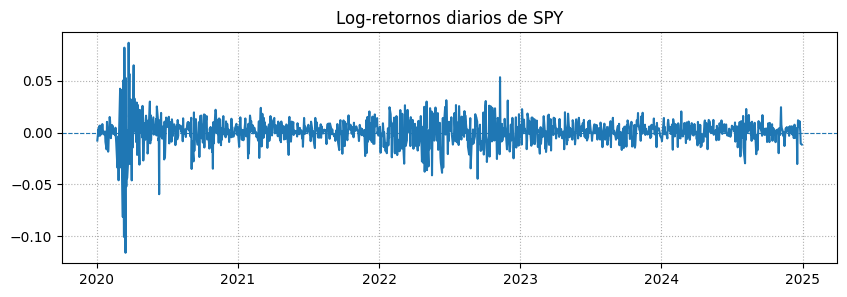

In [32]:
for ticker, df in data.items():
    plt.figure(figsize=(10,3))
    plt.plot(df["log_ret"])
    plt.title(f"Log-retornos diarios de {ticker}")
    plt.axhline(0, lw=0.8, ls="--")
    plt.grid(True, ls=":")
    plt.show()


***Yahoo Finance***

* Es un portal financiero que provee datos bursátiles, históricos y en tiempo real de acciones, ETFs, índices, bonos, divisas y más.
* Permite acceder a información como precios de apertura, cierre, máximos, mínimos, volumen de negociación, dividendos y splits.
* Es ampliamente usado por investigadores, analistas y traders, y su API es accesible mediante librerías como yfinance en Python.
* ***Limitaciones***: la API gratuita tiene restricciones de frecuencia de solicitudes (rate limits).

***SPY (SPDR S&P 500 ETF Trust)***

* Es un ETF que replica el índice S&P 500, compuesto por las 500 mayores empresas de EE.UU.
* Objetivo: reflejar el rendimiento del mercado estadounidense de gran capitalización.
* Es uno de los ETFs más líquidos y populares del mundo.
* Ideal para invertir en diversificación de mercado sin comprar acciones individuales.



### Selección de modelo ARMA

Se evaluaron modelos ARMA(p,q) para p,q en {0,1,2} y se seleccionó el mejor modelo según AIC y BIC. A continuación se ajusta el modelo seleccionado y se analizan sus residuos y bondad de ajuste.


In [33]:
import itertools
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

p = q = range(0, 3)
pq = list(itertools.product(p, q))

resultados = []

for p_i, q_i in pq:
    modelo = ARIMA(y, order=(p_i, 0, q_i))
    res = modelo.fit()

    resultados.append({
        "p": p_i,
        "q": q_i,
        "AIC": res.aic,
        "BIC": res.bic
    })

df_modelos = pd.DataFrame(resultados)

NameError: name 'y' is not defined

In [ ]:
df_modelos.sort_values("AIC").reset_index(drop=True)
(
    df_modelos
    .sort_values("AIC")
    .style
    .format({"AIC": "{:.2f}", "BIC": "{:.2f}"})
    .set_caption("Comparación de modelos ARMA(p,q) según AIC y BIC")
)

#### Modelo ARMA(p,q) que mejor describe los log-retornos

Para determinar el orden óptimo de un modelo ARMA(p,q), se suelen utilizar los Criterios de Información de Akaike (AIC) y Bayesiano (BIC). Estos criterios penalizan la complejidad del modelo (mayor número de parámetros) mientras buscan maximizar la bondad de ajuste.

Un valor más bajo de AIC o BIC indica un modelo preferido.

A partir de los resultados obtenidos:

*   **Mejor modelo según AIC**: `ARMA(0, 2)` con un AIC de aproximadamente -7324.18
*   **Mejor modelo según BIC**: `ARMA(0, 2)` con un BIC de aproximadamente -7303.64

Ambos criterios coinciden en que el modelo **ARMA(0, 2)**, que es equivalente a un modelo **MA(2)** (media móvil de orden 2), es el que mejor describe los log-retornos de la serie SPY dentro del rango de órdenes evaluado (p,q de 0 a 2).

Esto sugiere que la dependencia temporal en los log-retornos es mejor capturada por los errores pasados de hasta dos periodos, más que por los valores pasados de la serie (componente AR).

## 5. Análisis de residuos


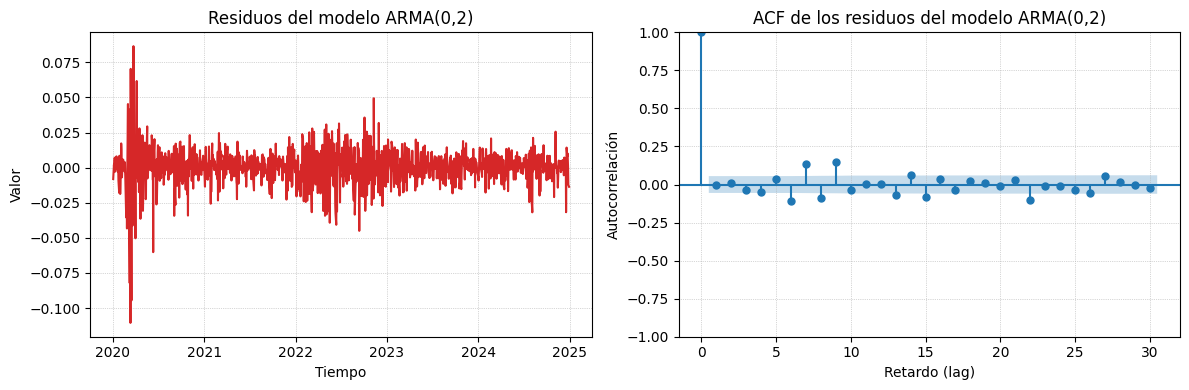

In [ ]:
# Ajustamos el modelo ARMA(0,2) a los datos, ya que fue el mejor según AIC y BIC

modelo_optimo = ARIMA(y, order=(0,0,2))
res_optimo = modelo_optimo.fit()

# Obtenemos los residuos del modelo ajustado
residuals_optimo = res_optimo.resid

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(residuals_optimo, color='tab:red')
axes[0].set_title("Residuos del modelo ARMA(0,2)")
axes[0].set_xlabel("Tiempo")
axes[0].set_ylabel("Valor")
axes[0].grid(True, lw=0.5, ls=":")

plot_acf(residuals_optimo, lags=30, ax=axes[1])
axes[1].set_title("ACF de los residuos del modelo ARMA(0,2)")
axes[1].set_xlabel("Retardo (lag)")
axes[1].set_ylabel("Autocorrelación")
axes[1].grid(True, lw=0.5, ls=":")

plt.tight_layout()
plt.show()

Los residuos del modelo ajustado se inspeccionan para comprobar ausencia de autocorrelación y comportamiento de ruido blanco. Si se detecta heterocedasticidad, se modela la volatilidad con GARCH para capturar cambios en la varianza condicional.


Los residuos no son ruido blanco puro. Aunque el gráfico ACF muestra que no hay correlación lineal (lo cual es positivo), el gráfico temporal revela que la varianza no es constante (hay periodos de mucha volatilidad y otros de calma), un fenómeno llamado heterocedasticidad.

Para modelar correctamente esos cambios en la volatilidad, el modelo indicado es de la familia GARCH.

In [ ]:
# ================================================================
# Inicialización: Aseguramos que las variables necesarias estén definidas
# ================================================================

# Aseguramos que y (log-retornos) esté definida
# Si no está definida, la cargamos desde los datos de SPY
if 'y' not in locals() and 'y' not in globals():
    # Cargamos los datos de SPY si no están cargados
    if 'sp' not in locals() and 'sp' not in globals():
        csv_file = "SPY.csv"
        if os.path.exists(csv_file):
            sp = pd.read_csv(csv_file, index_col="Date", parse_dates=True)
        else:
            print("Descargando datos de SPY...")
            sp = yf.download("SPY", start="2020-01-01", end="2024-12-31", auto_adjust=True)
            sp.index.name = "Date"
            sp.to_csv(csv_file)
    y = sp["log_ret"].dropna()

# Aseguramos que residuals esté definida (residuos del modelo óptimo)
if 'residuals' not in locals() and 'residuals' not in globals():
    if 'res_optimo' in locals() or 'res_optimo' in globals():
        residuals = res_optimo.resid
    else:
        # Si no existe res_optimo, ajustamos el modelo óptimo
        print("Ajustando modelo ARMA(0,2)...")
        modelo_optimo = ARIMA(y, order=(0,0,2))
        res_optimo = modelo_optimo.fit()
        residuals = res_optimo.resid

#print("Variables inicializadas correctamente para el análisis GARCH")


## 6. Modelo GARCH

Los modelos GARCH (Generalized Autoregressive Conditional Heteroskedasticity) son una extensión de los modelos ARCH que permiten modelar la volatilidad condicional de series financieras. Son especialmente útiles cuando se detecta heterocedasticidad en los residuos de modelos ARMA/ARIMA.

### ¿Por qué GARCH?

Como observamos en el análisis de residuos, la varianza de los log-retornos no es constante (heterocedasticidad). Los modelos GARCH capturan este comportamiento permitiendo que la varianza condicional dependa de:
- **Errores pasados al cuadrado** (componente ARCH)
- **Varianzas condicionales pasadas** (componente GARCH)

### Elección del Modelo GARCH(2,1)

Se eligió un modelo **GARCH(2,1)** donde:
- **p=2**: Dos términos ARCH (dependencia de errores pasados al cuadrado)
- **q=1**: Un término GARCH (dependencia de varianza condicional pasada)

Esta elección es común en la literatura financiera y proporciona un buen balance entre flexibilidad y parsimonia. Alternativamente, podrían evaluarse otros órdenes (GARCH(1,1), GARCH(1,2), etc.) usando criterios de información.

In [ ]:
# ================================================================
# Ajuste del modelo GARCH(2,1)
# ================================================================

# Nota: Multiplicamos y por 100 para trabajar con porcentajes y mejorar
# la estabilidad numérica del ajuste. Esto es una práctica común en modelado GARCH.
am = arch_model(y * 100, vol="Garch", p=2, q=1)
res_garch = am.fit(disp="off")

# Mostramos el resumen del modelo ajustado
# Este resumen incluye:
# - Coeficientes estimados y sus significancias estadísticas
# - Estadísticas de bondad de ajuste
# - Información sobre la distribución de los errores
res_garch.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

In [ ]:
conditional_vol = res_garch.conditional_volatility  # σ_t estimada

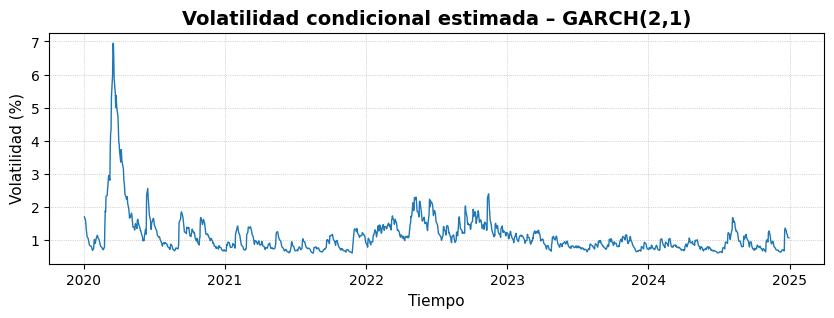

In [ ]:
plt.figure(figsize=(10,3))
plt.plot(vol, lw=1)
plt.title(
    "Volatilidad condicional estimada – GARCH(2,1)",
    fontsize=14,
    fontweight="bold"
)
plt.xlabel("Tiempo", fontsize=11)
plt.ylabel("Volatilidad (%)", fontsize=11)
plt.grid(True, lw=0.5, ls=":")
plt.show()

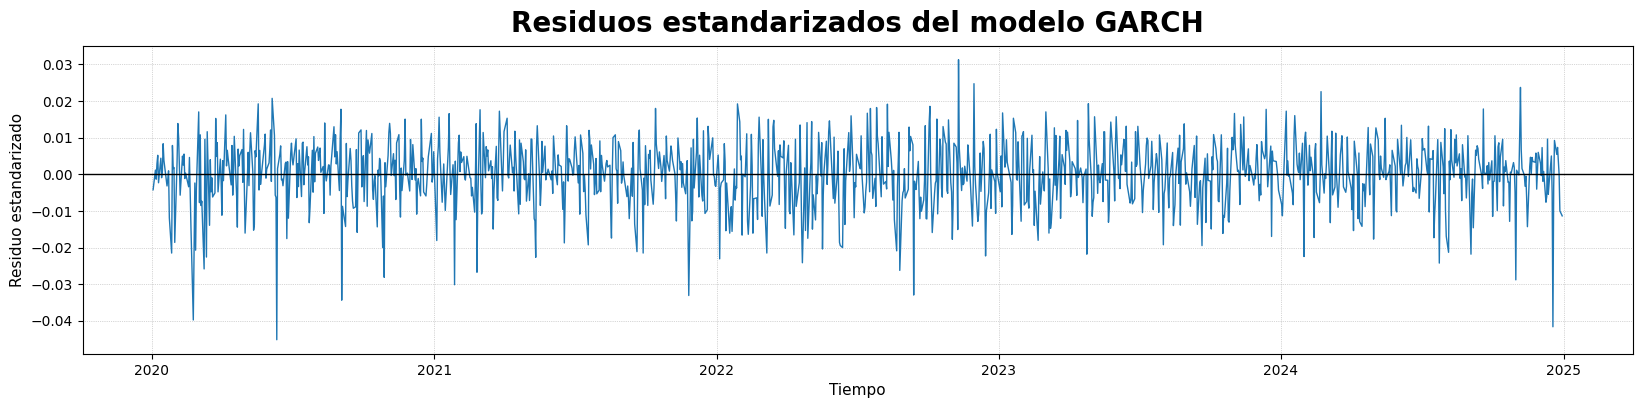

In [ ]:
std_resid = residuals / conditional_vol

plt.figure(figsize=(20,4))
plt.plot(std_resid / conditional_vol.mean(), lw=1)
plt.title(
    "Residuos estandarizados del modelo GARCH",
    fontsize=20,
    fontweight="bold",
    pad=10
)
plt.axhline(0, color='black', linewidth=1)
plt.xlabel("Tiempo", fontsize=11)
plt.ylabel("Residuo estandarizado", fontsize=11)
plt.grid(True, lw=0.5, ls=":")
plt.show()


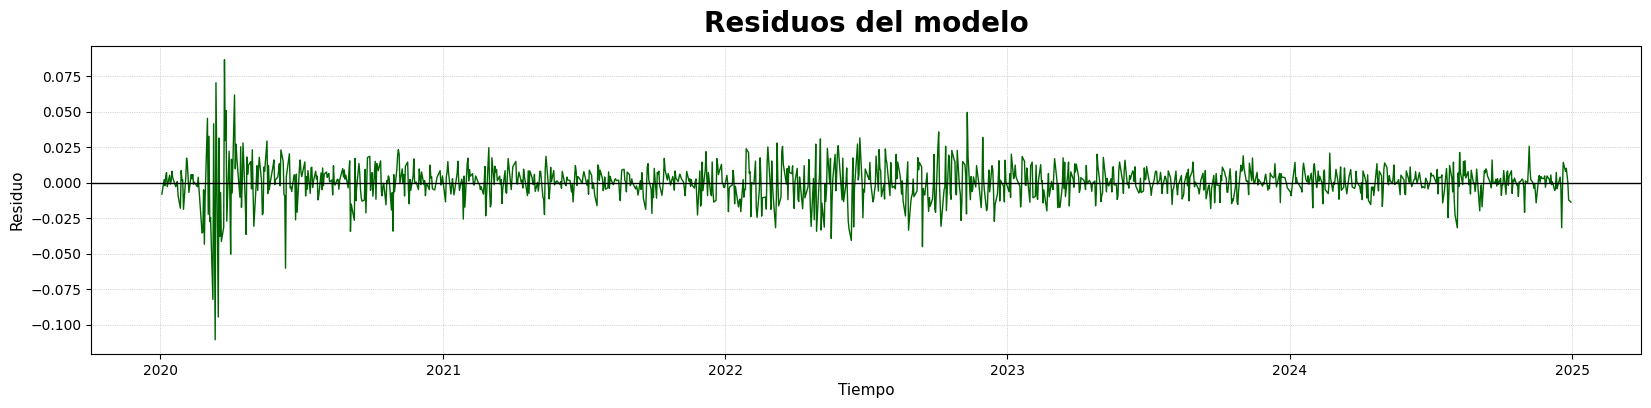

In [ ]:
plt.figure(figsize=(20,4))
plt.plot(residuals, lw=1, color='darkgreen')
plt.title(
    "Residuos del modelo",
    fontsize=20,
    fontweight="bold",
    pad=10
)
plt.axhline(0, color='black', linewidth=1)
plt.xlabel("Tiempo", fontsize=11)
plt.ylabel("Residuo", fontsize=11)
plt.grid(True, lw=0.5, ls=":")
plt.show()


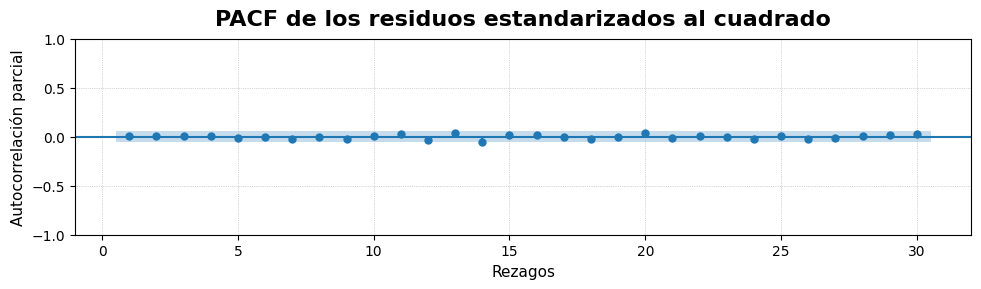

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(10,3))

plot_pacf(
    std_resid**2,
    lags=30,
    zero=False,
    method="ywm",
    ax=ax
)

ax.set_title(
    "PACF de los residuos estandarizados al cuadrado",
    fontsize=16,
    fontweight="bold",
    pad=10
)
ax.set_xlabel("Rezagos", fontsize=11)
ax.set_ylabel("Autocorrelación parcial", fontsize=11)
ax.grid(True, lw=0.5, ls=":")

plt.tight_layout()
plt.show()


## 7. Conclusiones y Resumen del Análisis

Este análisis ha demostrado la aplicación de técnicas avanzadas de series de tiempo a datos financieros reales. A continuación se resumen los hallazgos principales:

### Hallazgos Principales

1. **Modelo Óptimo para Log-Retornos de SPY:**

   - El modelo **ARMA(0,2)** fue seleccionado como el mejor según los criterios AIC y BIC
   - Esto indica que los log-retornos diarios del ETF SPY se modelan mejor como un proceso de media móvil de orden 2
   - La dependencia temporal se captura principalmente a través de los errores pasados, no de los valores pasados de la serie

2. **Análisis de Residuos:**

   - Los residuos del modelo ARMA(0,2) muestran ausencia de autocorrelación lineal (confirmado por ACF)
   - Sin embargo, se detectó **heterocedasticidad**: la varianza de los residuos no es constante
   - Esto es común en series financieras y requiere modelado adicional de la volatilidad

3. **Modelado de Volatilidad con GARCH:**

   - Se implementó un modelo **GARCH(2,1)** para capturar los cambios en la volatilidad condicional
   - El modelo GARCH permite modelar los períodos de alta y baja volatilidad observados en los datos
   - Los residuos estandarizados muestran mejor comportamiento después del ajuste GARCH

### Limitaciones y Consideraciones

- **Período de análisis:** Los datos analizados cubren el período 2020-2024, que incluye eventos significativos como la pandemia COVID-19
- **Elección de modelo GARCH:** Se utilizó GARCH(2,1) como ejemplo, pero otros órdenes podrían ser evaluados
- **Datos:** El análisis se limitó al ETF SPY; sería interesante comparar con otros activos financieros

### Aplicaciones Prácticas

Los modelos desarrollados pueden utilizarse para:
- **Pronóstico de volatilidad:** Predecir períodos de alta/baja volatilidad
- **Gestión de riesgo:** Evaluar el riesgo de inversión basado en volatilidad condicional
- **Trading cuantitativo:** Desarrollar estrategias basadas en patrones de volatilidad

### Habilidades Demostradas

Este proyecto demuestra competencia en:
- ✅ Análisis exploratorio de series temporales financieras
- ✅ Modelado ARMA/ARIMA con selección de modelos
- ✅ Diagnóstico de residuos y detección de heterocedasticidad
- ✅ Modelado de volatilidad con GARCH
- ✅ Visualización efectiva de resultados
- ✅ Código reproducible y bien documentado

---

**Nota:** Este análisis es educativo y no constituye asesoramiento financiero. Los modelos de series de tiempo son herramientas útiles pero tienen limitaciones y deben usarse con precaución en decisiones de inversión reales.
